# Sampling

**Goal:** ...
  
This notebook is divided in two parts:
* **1. Bla**

In [1]:
%run ../setup_environment.ipy
%run ../Selene_Job.ipy

Setup environment... done!


<span style="color:green">✅ Working on **impact-annotator_env** conda environment.</span>

In [2]:
summary = pd.DataFrame(columns=['test_accuracy', 'test_roc_auc', 'test_f1', 'test_average_precision'])
summary.index.name = 'sampling_strategy'

## Get the data

In [3]:
# get raw data
impact = pd.read_csv('../../../data/annotated_final_IMPACT_mutations_180508.txt', sep='\t', low_memory=False)

# create the is_artefact class
impact['is_artefact'] = impact.confidence_class == "UNLIKELY"
get_table(impact.is_artefact)

# choose label
label = 'is_artefact'

# choose features
features = ['t_depth', 't_vaf', 't_alt_count', 'n_depth', 'n_vaf', 'n_alt_count', 'sample_coverage', 'frequency_in_normals',
            'VEP_Consequence', 'VEP_VARIANT_CLASS', 'VEP_IMPACT', 'VEP_CLIN_SIG', 'VEP_COSMIC_CNT', 'VEP_gnomAD_AF', 'VEP_in_dbSNP',
            'VEP_gnomAD_total_AF_AFR', 'VEP_gnomAD_total_AF_AMR', 'VEP_gnomAD_total_AF_ASJ', 'VEP_gnomAD_total_AF_EAS', 'VEP_gnomAD_total_AF_FIN',
            'VEP_gnomAD_total_AF_NFE', 'VEP_gnomAD_total_AF_OTH', 'VEP_gnomAD_total_AF_max', 'VEP_gnomAD_total_AF', 'Kaviar_AF',
            'gene_type']
impact = impact[features + [label]].dropna()
    
# transform categorical features
categorical_features = ['VEP_Consequence', 'VEP_VARIANT_CLASS', 'VEP_IMPACT', 'VEP_CLIN_SIG', 'VEP_in_dbSNP', 'gene_type']
numerical_features = [f for f in features if not f in categorical_features]
impact = pd.get_dummies(impact, columns=categorical_features, sparse=True)

In [4]:
positive_class_number = impact[impact.is_artefact].shape[0]

def get_X_and_y(seed):
    # get selected dataset
    impact_selected = pd.concat([impact[impact.is_artefact],
                                 impact[~impact.is_artefact].iloc[seed * positive_class_number:(seed + 1) * positive_class_number]], ignore_index=True)

    # shuffle data
    rng = np.random.RandomState(42)
    permutation = rng.permutation(len(impact_selected))
    impact_selected = impact_selected.iloc[permutation]
    impact_selected.reset_index(drop=True, inplace=True)

    # get features matrix X (n_samples x n_features) and target array y (n_samples)
    X = impact_selected.drop(label, axis=1)
    X = X.astype(float)
    y = impact_selected[label]

    print(X.shape)
    print(y.shape)
    display(get_table(y))
    
    return (X, y)

In [5]:
X_1, y_1 = get_X_and_y(0)
X_2, y_2 = get_X_and_y(1)
X_3, y_3 = get_X_and_y(2)

(14398, 45)
(14398,)


count_  freq_
True     7199  50.0%
False    7199  50.0%

(14398, 45)
(14398,)


count_  freq_
True     7199  50.0%
False    7199  50.0%

(14398, 45)
(14398,)


count_  freq_
True     7199  50.0%
False    7199  50.0%

In [6]:
dataset_dict = {'sampling_1': {'X': X_1, 'y': y_1, 'metrics': pd.DataFrame()},
                'sampling_2': {'X': X_2, 'y': y_2, 'metrics': pd.DataFrame()},
                'sampling_3': {'X': X_3, 'y': y_3, 'metrics': pd.DataFrame()}}

## Set cross-validation strategies

We choose stratified folds (made by preserving the percentage of samples for each class) for both outer and nested cross-validation.

In [7]:
from sklearn.model_selection import StratifiedKFold
cv_strategy = StratifiedKFold(n_splits=5)
nested_cv_strategy = StratifiedKFold(n_splits=3)

## Ridge Regression (L2 regularization)

In [8]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

model = Pipeline([('scale'   , StandardScaler()),
                  ('classify', LogisticRegressionCV(cv=nested_cv_strategy, scoring='roc_auc', random_state=42))])

for key in dataset_dict.keys():
    print_md('**' + key + '**')
    dataset_dict[key]['metrics'] = run_model(model, dataset_dict[key]['X'], dataset_dict[key]['y'], cv_strategy, n_jobs=5)
    print_mean_metrics(dataset_dict[key]['metrics'])

**sampling_1**

Run model... done! (4.82s)
▴ Mean accuracy    : 0.820 ± 0.006
▴ Mean ROC AUC     : 0.891 ± 0.010
▴ Mean F1-score    : 0.803 ± 0.011
▴ Average precision: 0.912 ± 0.006


**sampling_2**

Run model... done! (3.40s)
▴ Mean accuracy    : 0.819 ± 0.020
▴ Mean ROC AUC     : 0.887 ± 0.019
▴ Mean F1-score    : 0.801 ± 0.022
▴ Average precision: 0.912 ± 0.015


**sampling_3**

Run model... done! (3.47s)
▴ Mean accuracy    : 0.866 ± 0.016
▴ Mean ROC AUC     : 0.926 ± 0.016
▴ Mean F1-score    : 0.858 ± 0.019
▴ Average precision: 0.943 ± 0.012


**sampling_1**

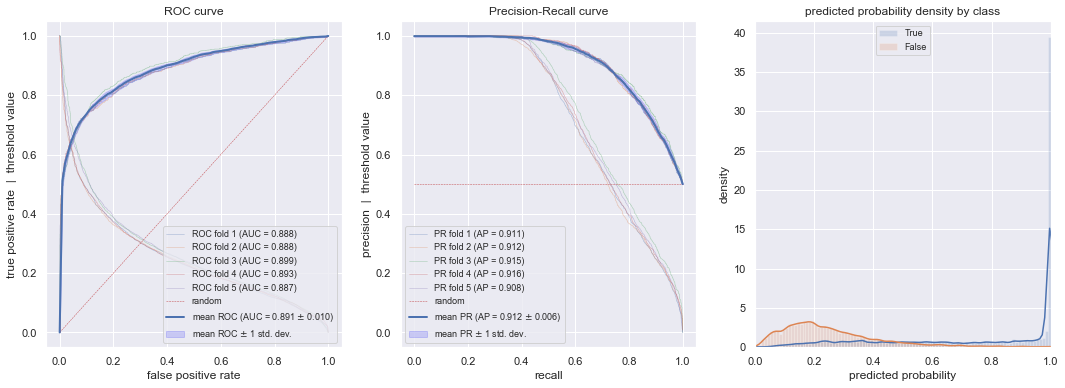

**sampling_2**

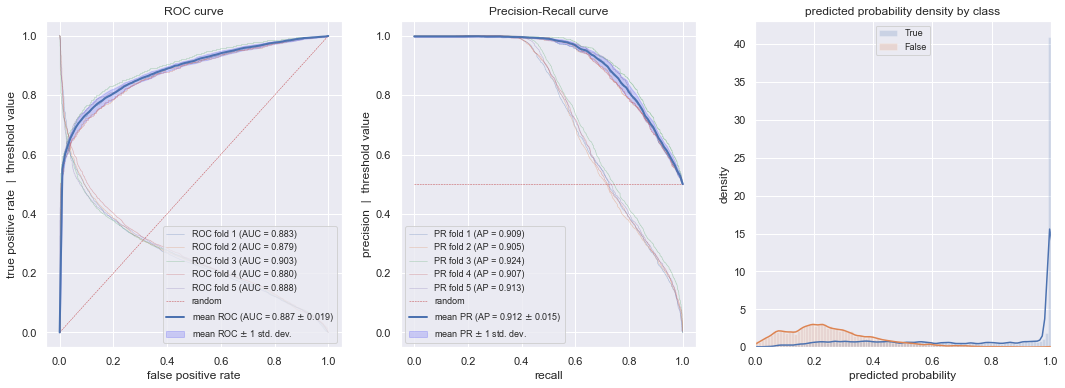

**sampling_3**

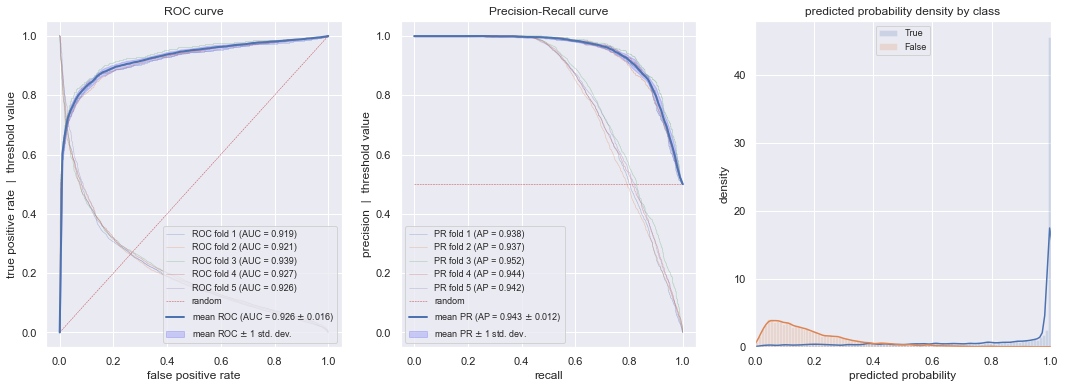

In [9]:
for key in dataset_dict.keys():
    print_md('**' + key + '**')
    plot_threshold_decision_metrics(dataset_dict[key]['metrics'], figsize=(18, 6))
    plt.show()

**sampling_1**

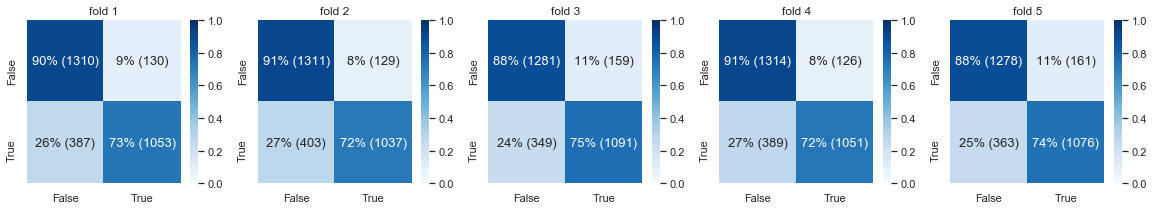

**sampling_2**

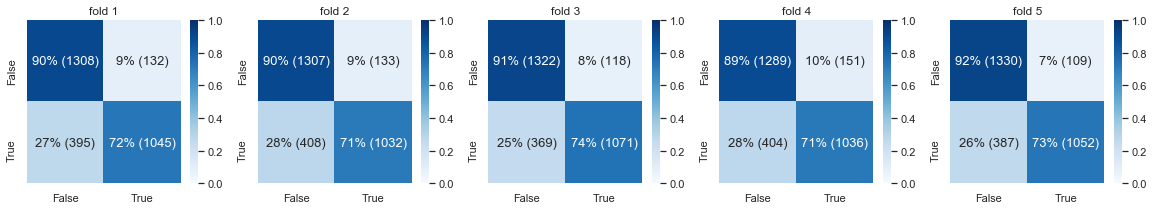

**sampling_3**

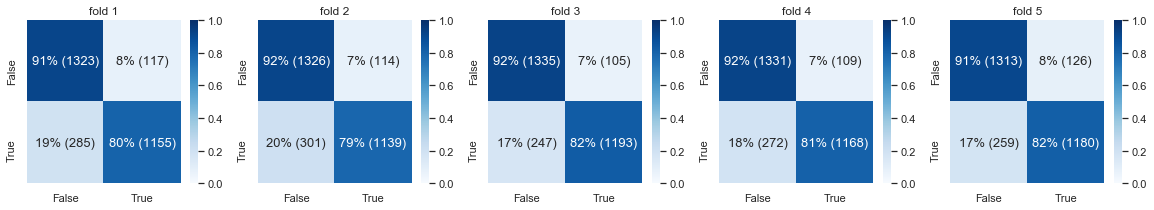

In [10]:
for key in dataset_dict.keys():
    print_md('**' + key + '**')
    plot_confusion_matrix(dataset_dict[key]['metrics'])
    plt.show()

In [12]:
for key in dataset_dict.keys():
    metrics = dataset_dict[key]['metrics']
    summary.loc['RidgeRegression_%s' % key] = [metrics.test_accuracy.mean(), metrics.test_roc_auc.mean(), metrics.test_f1.mean(), metrics.test_average_precision.mean()]

## Random Forest

### Create job

In [41]:
job_list = []
for key in dataset_dict.keys():
    job_list.append(Selene_Job('RandomForest_%s' % key, 'guilminp', '/home/guilminp/impact-annotator', '../ssh_remote_jobs'))

<span style="color:red">Job < RandomForest_sampling_1 >: </span>⚠️ job already exists, please remove it with `job.remove()` or use `load_from_id = True` to reload the existing job<br>

<span style="color:red">Job < RandomForest_sampling_2 >: </span>⚠️ job already exists, please remove it with `job.remove()` or use `load_from_id = True` to reload the existing job<br>

<span style="color:red">Job < RandomForest_sampling_3 >: </span>⚠️ job already exists, please remove it with `job.remove()` or use `load_from_id = True` to reload the existing job<br>

In [14]:
job_list = []
for key in dataset_dict.keys():
    job_list.append(Selene_Job('RandomForest_%s' % key, 'guilminp', '/home/guilminp/impact-annotator', '../ssh_remote_jobs', load_from_id=True))

<span style="color:green">Job < RandomForest_sampling_1 >: </span>✅ job found and reloaded

<span style="color:green">Job < RandomForest_sampling_2 >: </span>✅ job found and reloaded

<span style="color:green">Job < RandomForest_sampling_3 >: </span>✅ job found and reloaded

In [44]:
for job in job_list:
    job.load_data(dataset_dict[job.job_id[13:]]['X'], dataset_dict[job.job_id[13:]]['y'])

➞ save X.pkl & y.pkl in ../ssh_remote_jobs/job_RandomForest_sampling_1


<span style="color:green">Job < RandomForest_sampling_1 >: </span>✅ data loaded

➞ save X.pkl & y.pkl in ../ssh_remote_jobs/job_RandomForest_sampling_2


<span style="color:green">Job < RandomForest_sampling_2 >: </span>✅ data loaded

➞ save X.pkl & y.pkl in ../ssh_remote_jobs/job_RandomForest_sampling_3


<span style="color:green">Job < RandomForest_sampling_3 >: </span>✅ data loaded

In [46]:
%%writefile {job_list[0].script_path}

# load the ml_tools functions
%run ../../ml_tools.py

# load the features matrix and target array
X = pd.read_pickle('X.pkl')
y = pd.read_pickle('y.pkl')

# setup cross-validation and import modules
from sklearn.model_selection import StratifiedKFold
cv_strategy = StratifiedKFold(n_splits=5)
nested_cv_strategy = StratifiedKFold(n_splits=3)

# choose a model and run it
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
parameters_grid = [
    {'n_estimators': [100, 500, 1000, 1500], 'criterion': ['gini', 'entropy'], 'max_depth': [10, 20, 30, 40, 50]}
]
model = GridSearchCV(RandomForestClassifier(random_state=42), parameters_grid, cv=nested_cv_strategy, scoring='roc_auc', refit=True, return_train_score=True)
metrics = run_model(model, X, y, cv_strategy, n_jobs=10)

# save the metrics
print('Save metrics...', end='')
metrics.to_pickle('metrics.pkl')
print(' done!')

Overwriting ../ssh_remote_jobs/job_RandomForest_sampling_1/script.ipy


In [47]:
!cp {job_list[0].script_path} {job_list[1].script_path}
!cp {job_list[0].script_path} {job_list[2].script_path}

In [48]:
for job in job_list:
    job.run(n_jobs=10, short_job=True, memory=16)

➞ scp ../ssh_remote_jobs/job_RandomForest_sampling_1 to guilminp@selene.mskcc.org:/home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs
job_output.txt                                100% 1535     1.5KB/s   00:01    
metrics.pkl                                   100%  477KB 612.5KB/s   00:00    
script.ipy                                    100%  925     0.9KB/s   00:01    
X.pkl                                         100% 3268KB   3.9MB/s   00:00    
y.pkl                                         100%   15KB  24.1KB/s   00:00    
➞ logged in /home/guilminp on selene.cbio.private
➞ load ~/.bash_profile
Hi Pierre!
➞ work on impact-annotator_env python virtualenv
➞ rm metrics.pkl & job_output.txt in /home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs/job_RandomForest_sampling_1
Job <28725787> is submitted to default queue <sol>.
➞ bsub command used: $ bsub -o job_output.txt -J RandomForest_sampling_1 -We 59 -n 10 -R "span[ptile=5,mem=16]" "ipython script.ipy"

<span style="color:green">Job < RandomForest_sampling_1 >: </span>✅ submitted<br>

➞ scp ../ssh_remote_jobs/job_RandomForest_sampling_2 to guilminp@selene.mskcc.org:/home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs
job_output.txt                                100% 1535     3.1KB/s   00:00    
metrics.pkl                                   100%  497KB 824.2KB/s   00:00    
script.ipy                                    100%  925     0.9KB/s   00:01    
X.pkl                                         100% 3268KB   3.5MB/s   00:00    
y.pkl                                         100%   15KB 878.5KB/s   00:00    
➞ logged in /home/guilminp on selene.cbio.private
➞ load ~/.bash_profile
Hi Pierre!
➞ work on impact-annotator_env python virtualenv
➞ rm metrics.pkl & job_output.txt in /home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs/job_RandomForest_sampling_2
Job <28725789> is submitted to default queue <sol>.
➞ bsub command used: $ bsub -o job_output.txt -J RandomForest_sampling_2 -We 59 -n 10 -R "span[ptile=5,mem=16]" "ipython script.ipy"

<span style="color:green">Job < RandomForest_sampling_2 >: </span>✅ submitted<br>

➞ scp ../ssh_remote_jobs/job_RandomForest_sampling_3 to guilminp@selene.mskcc.org:/home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs
job_output.txt                                100% 1535     1.5KB/s   00:01    
metrics.pkl                                   100%  453KB 553.5KB/s   00:00    
script.ipy                                    100%  925     1.3KB/s   00:00    
X.pkl                                         100% 3268KB   3.2MB/s   00:01    
y.pkl                                         100%   15KB  92.3KB/s   00:00    
➞ logged in /home/guilminp on selene.cbio.private
➞ load ~/.bash_profile
Hi Pierre!
➞ work on impact-annotator_env python virtualenv
➞ rm metrics.pkl & job_output.txt in /home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs/job_RandomForest_sampling_3
Job <28725791> is submitted to default queue <sol>.
➞ bsub command used: $ bsub -o job_output.txt -J RandomForest_sampling_3 -We 59 -n 10 -R "span[ptile=5,mem=16]" "ipython script.ipy"

<span style="color:green">Job < RandomForest_sampling_3 >: </span>✅ submitted<br>

In [15]:
for job in job_list:
    job.get_results()

<span style="color:green">Job < RandomForest_sampling_1 >: </span>✅ finished<br>

➞ scp metrics.pkl & job_output.txt from guilminp@selene.mskcc.org:/home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs/job_RandomForest_sampling_1 to ../ssh_remote_jobs/job_RandomForest_sampling_1
metrics.pkl                                   100%  472KB   8.5MB/s   00:00    
job_output.txt                                100% 1533   191.7KB/s   00:00    
➞ load metrics.pkl in pandas dataframe self.metrics
➞ print main results
▴ Mean accuracy    : 0.864 ± 0.008
▴ Mean ROC AUC     : 0.937 ± 0.009
▴ Mean F1-score    : 0.859 ± 0.008
▴ Average precision: 0.948 ± 0.007


<span style="color:green">Job < RandomForest_sampling_2 >: </span>✅ finished<br>

➞ scp metrics.pkl & job_output.txt from guilminp@selene.mskcc.org:/home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs/job_RandomForest_sampling_2 to ../ssh_remote_jobs/job_RandomForest_sampling_2
metrics.pkl                                   100%  492KB   4.0MB/s   00:00    
job_output.txt                                100% 1533   207.4KB/s   00:00    
➞ load metrics.pkl in pandas dataframe self.metrics
➞ print main results
▴ Mean accuracy    : 0.860 ± 0.015
▴ Mean ROC AUC     : 0.933 ± 0.011
▴ Mean F1-score    : 0.853 ± 0.016
▴ Average precision: 0.944 ± 0.010


<span style="color:green">Job < RandomForest_sampling_3 >: </span>✅ finished<br>

➞ scp metrics.pkl & job_output.txt from guilminp@selene.mskcc.org:/home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs/job_RandomForest_sampling_3 to ../ssh_remote_jobs/job_RandomForest_sampling_3
metrics.pkl                                   100%  447KB   8.0MB/s   00:00    
job_output.txt                                100% 1531   121.4KB/s   00:00    
➞ load metrics.pkl in pandas dataframe self.metrics
➞ print main results
▴ Mean accuracy    : 0.896 ± 0.013
▴ Mean ROC AUC     : 0.958 ± 0.009
▴ Mean F1-score    : 0.894 ± 0.014
▴ Average precision: 0.964 ± 0.008


**RandomForest_sampling_1**

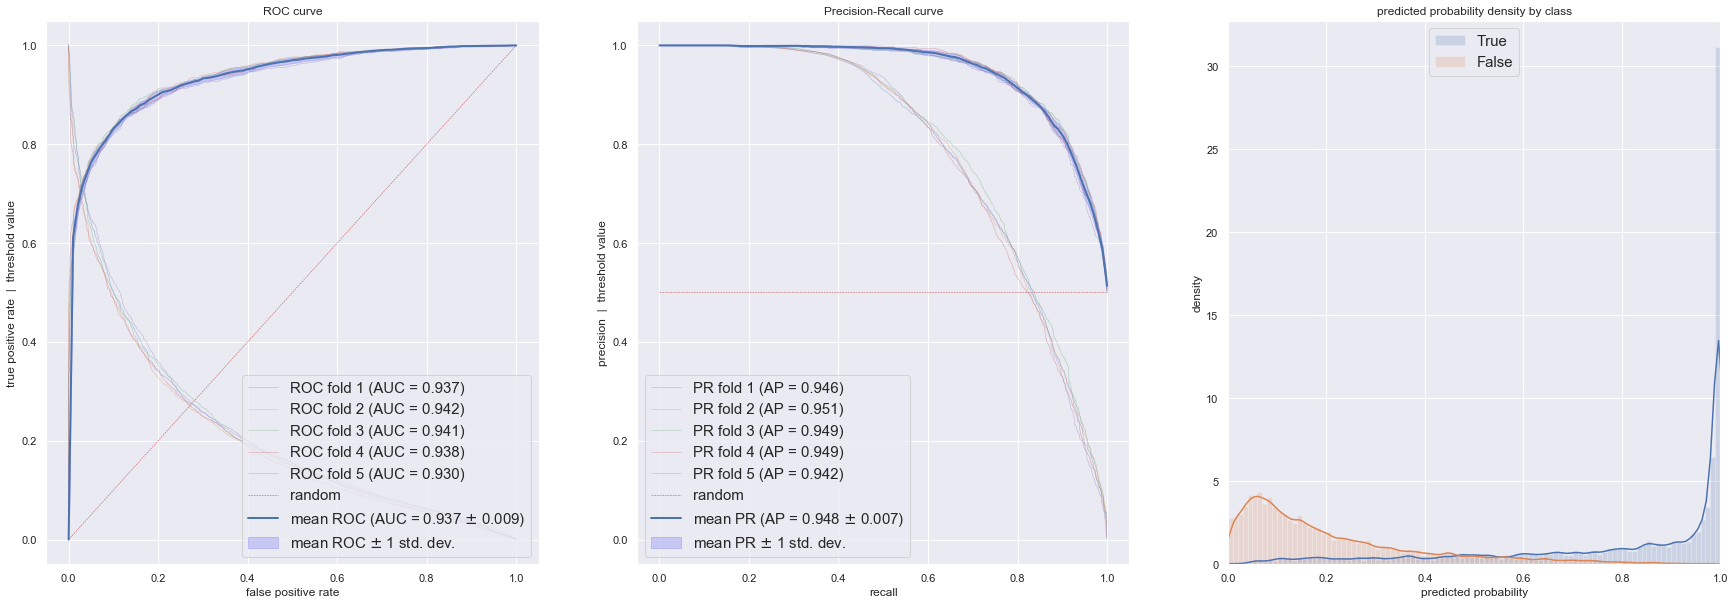

**RandomForest_sampling_2**

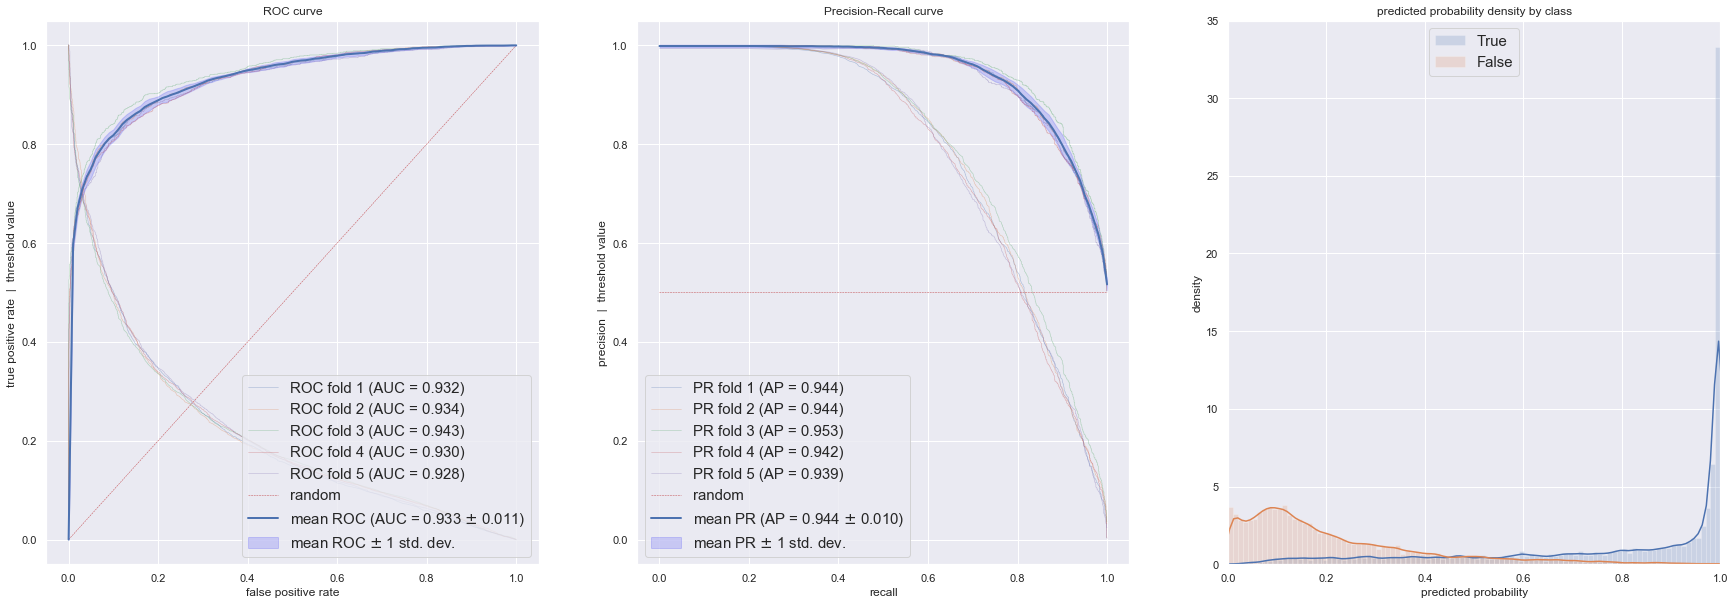

**RandomForest_sampling_3**

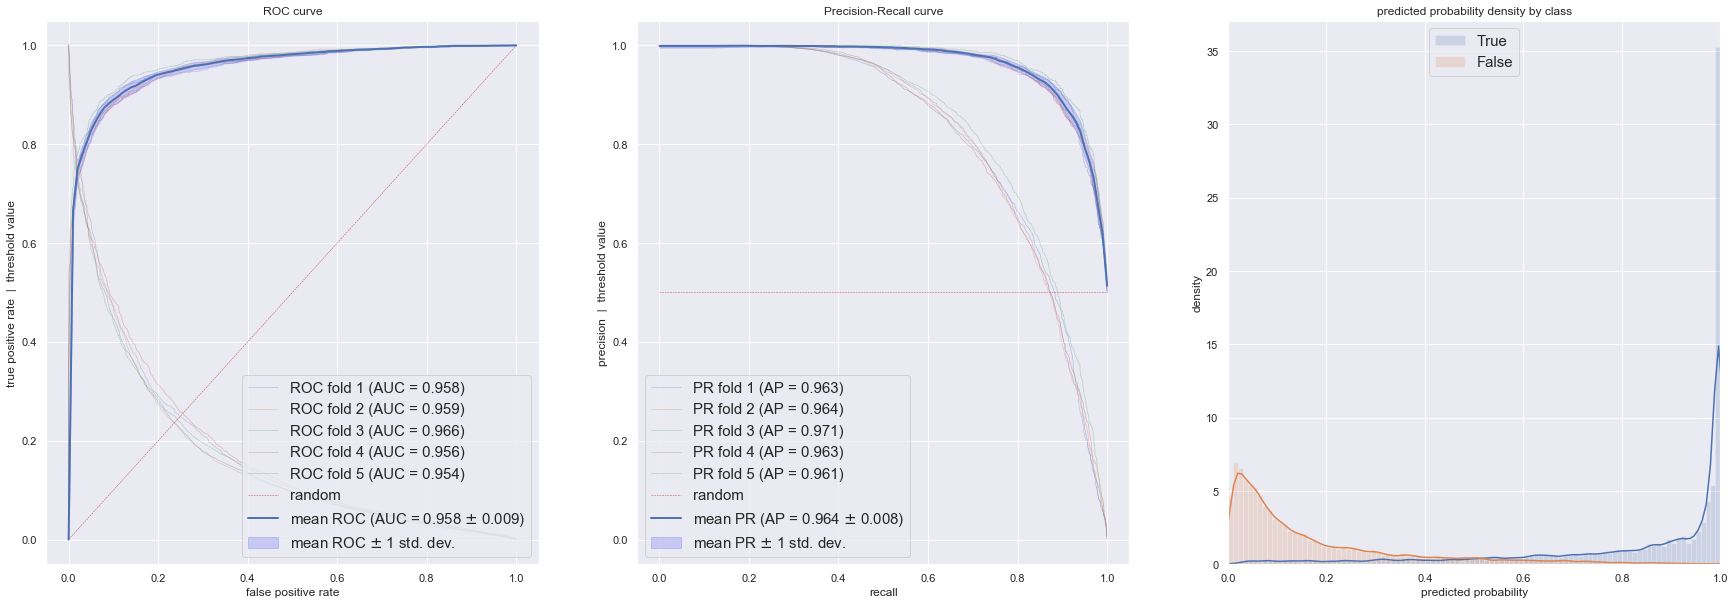

In [194]:
for job in job_list:
    if hasattr(job, 'metrics'):
        print_md('**' + job.job_id + '**')
        plot_threshold_decision_metrics(job.metrics)
        plt.show()

**RandomForest_sampling_1**

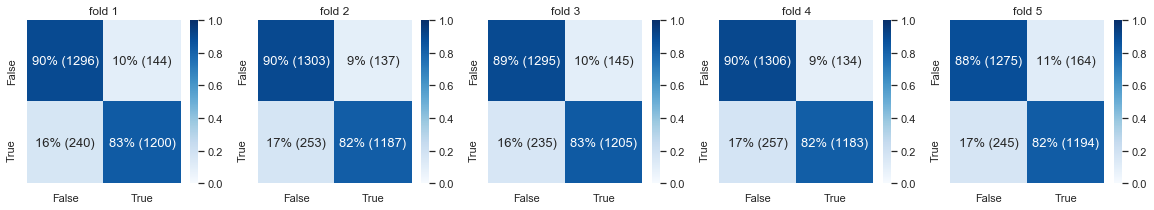

**RandomForest_sampling_2**

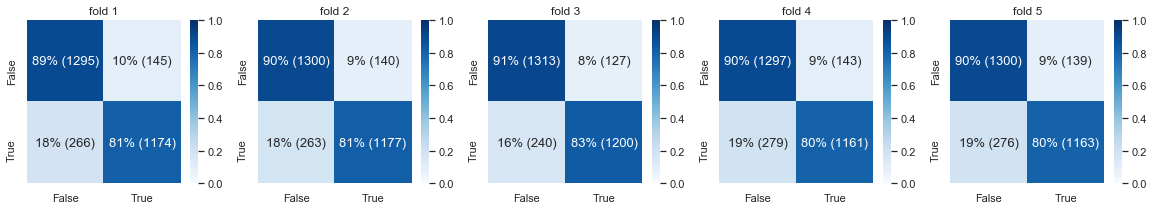

**RandomForest_sampling_3**

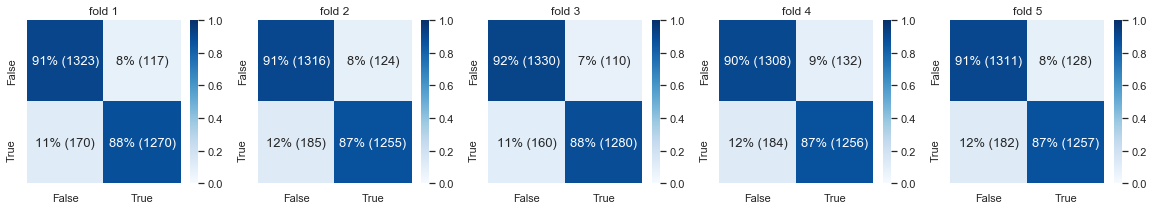

In [195]:
for job in job_list:
    if hasattr(job, 'metrics'):
        print_md('**' + job.job_id + '**')
        plot_confusion_matrix(job.metrics)
        plt.show()

**RandomForest_sampling_1**

3 hyperparameters tuned for 5 different folds (over a 3-fold nested cross-validation):
  → criterion   : ['entropy' 'gini']
  → max_depth   : [10 20 30 40 50]
  → n_estimators: [100 500 1000 1500]
Best hyperparameters for each fold:
fold 0: {'criterion': 'entropy', 'max_depth': 30, 'n_estimators': 1500}
fold 1: {'criterion': 'entropy', 'max_depth': 30, 'n_estimators': 1500}
fold 2: {'criterion': 'entropy', 'max_depth': 30, 'n_estimators': 1000}
fold 3: {'criterion': 'entropy', 'max_depth': 40, 'n_estimators': 1500}
fold 4: {'criterion': 'entropy', 'max_depth': 50, 'n_estimators': 1000}


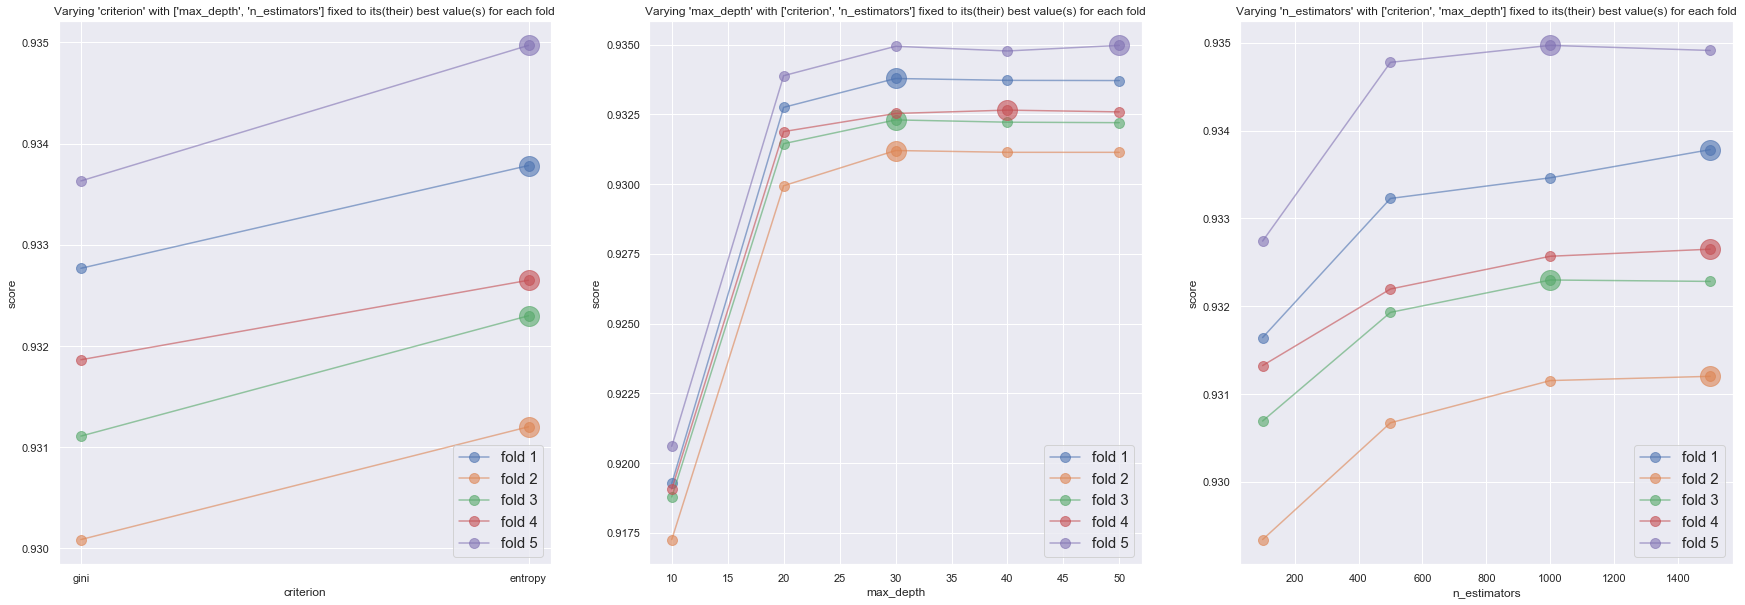

**RandomForest_sampling_2**

3 hyperparameters tuned for 5 different folds (over a 3-fold nested cross-validation):
  → criterion   : ['entropy' 'gini']
  → max_depth   : [10 20 30 40 50]
  → n_estimators: [100 500 1000 1500]
Best hyperparameters for each fold:
fold 0: {'criterion': 'entropy', 'max_depth': 40, 'n_estimators': 1500}
fold 1: {'criterion': 'entropy', 'max_depth': 30, 'n_estimators': 1500}
fold 2: {'criterion': 'entropy', 'max_depth': 30, 'n_estimators': 1500}
fold 3: {'criterion': 'entropy', 'max_depth': 30, 'n_estimators': 1000}
fold 4: {'criterion': 'entropy', 'max_depth': 30, 'n_estimators': 500}


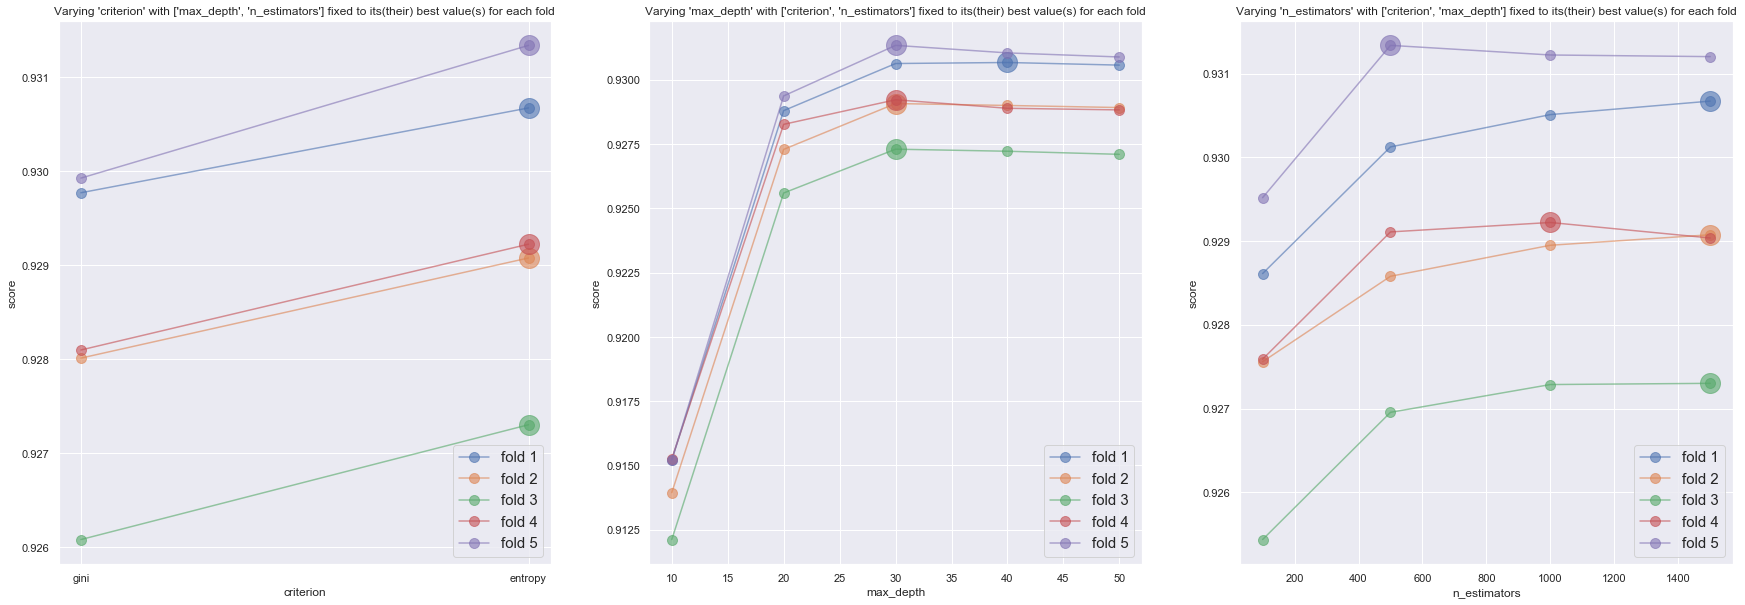

**RandomForest_sampling_3**

3 hyperparameters tuned for 5 different folds (over a 3-fold nested cross-validation):
  → criterion   : ['entropy' 'gini']
  → max_depth   : [10 20 30 40 50]
  → n_estimators: [100 500 1000 1500]
Best hyperparameters for each fold:
fold 0: {'criterion': 'entropy', 'max_depth': 30, 'n_estimators': 1500}
fold 1: {'criterion': 'entropy', 'max_depth': 40, 'n_estimators': 1500}
fold 2: {'criterion': 'entropy', 'max_depth': 30, 'n_estimators': 1000}
fold 3: {'criterion': 'entropy', 'max_depth': 50, 'n_estimators': 1000}
fold 4: {'criterion': 'entropy', 'max_depth': 40, 'n_estimators': 1500}


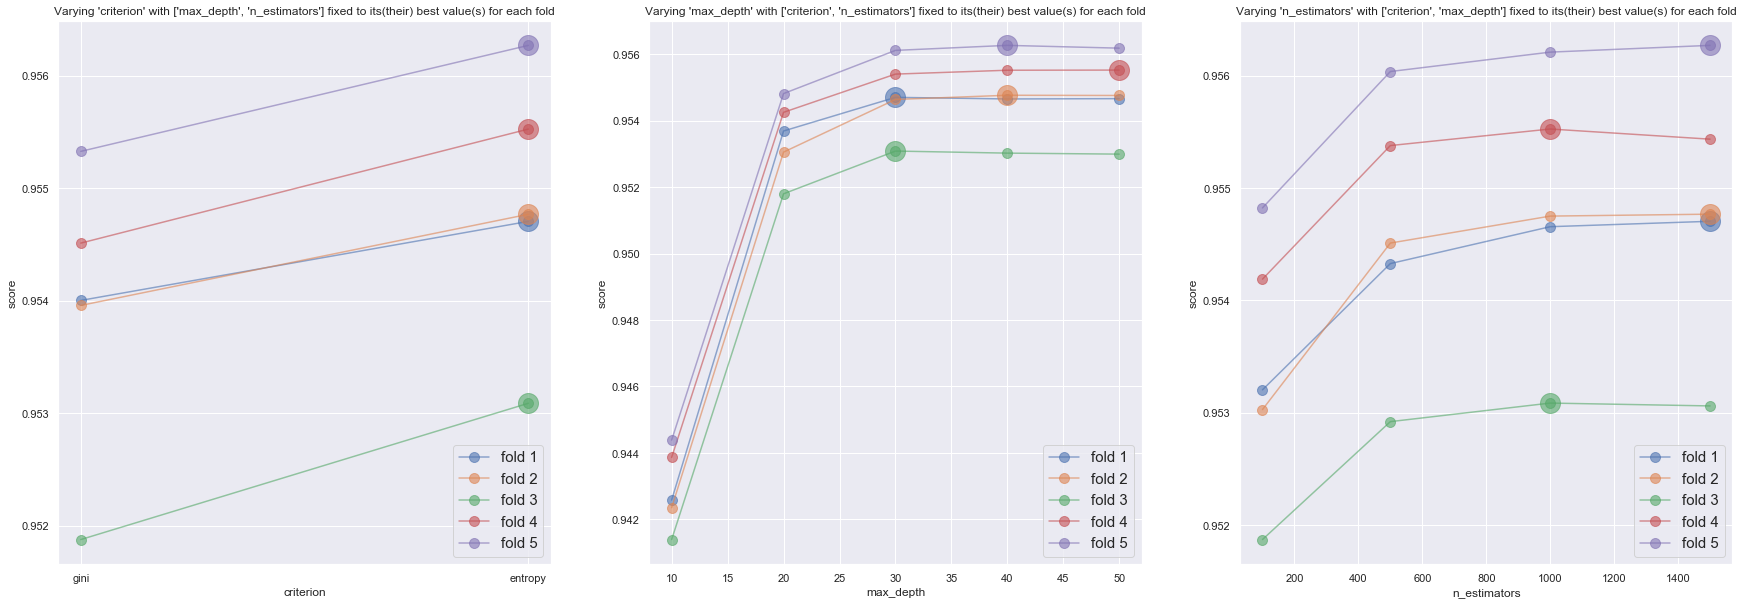

In [196]:
for job in job_list:
    if hasattr(job, 'metrics'):
        print_md('**' + job.job_id + '**')
        plot_grid_search_results(job.metrics, plot_error_bar=False)
        plt.show()

In [16]:
for job in job_list:
    if hasattr(job, 'metrics'):
        summary.loc[job.job_id] = [job.metrics.test_accuracy.mean(), job.metrics.test_roc_auc.mean(), job.metrics.test_f1.mean(), job.metrics.test_average_precision.mean()]

### Study feature importance of the best hyperparameted classifier

**sampling_1**

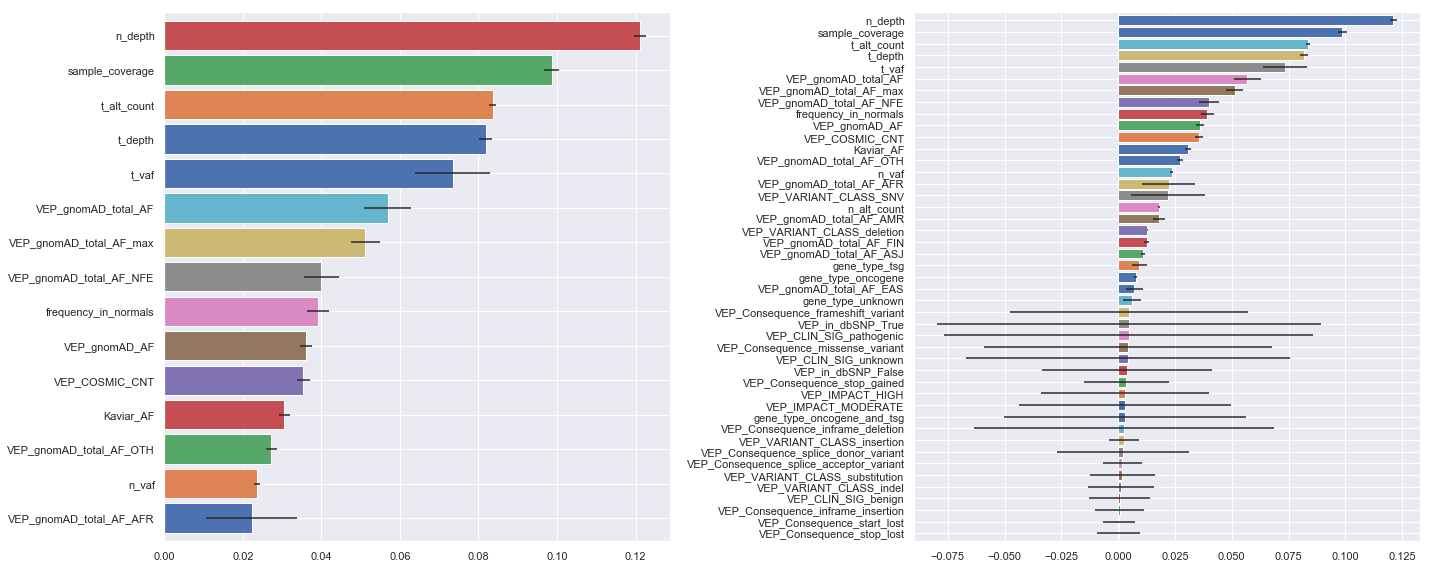

**sampling_2**

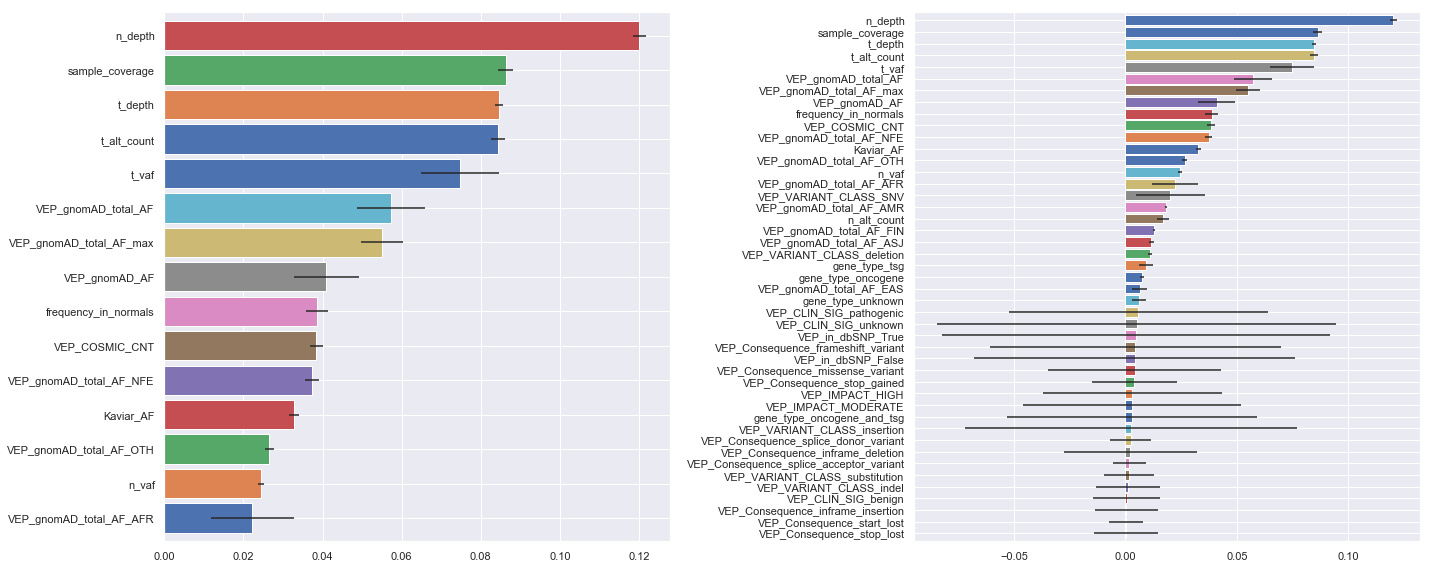

**sampling_3**

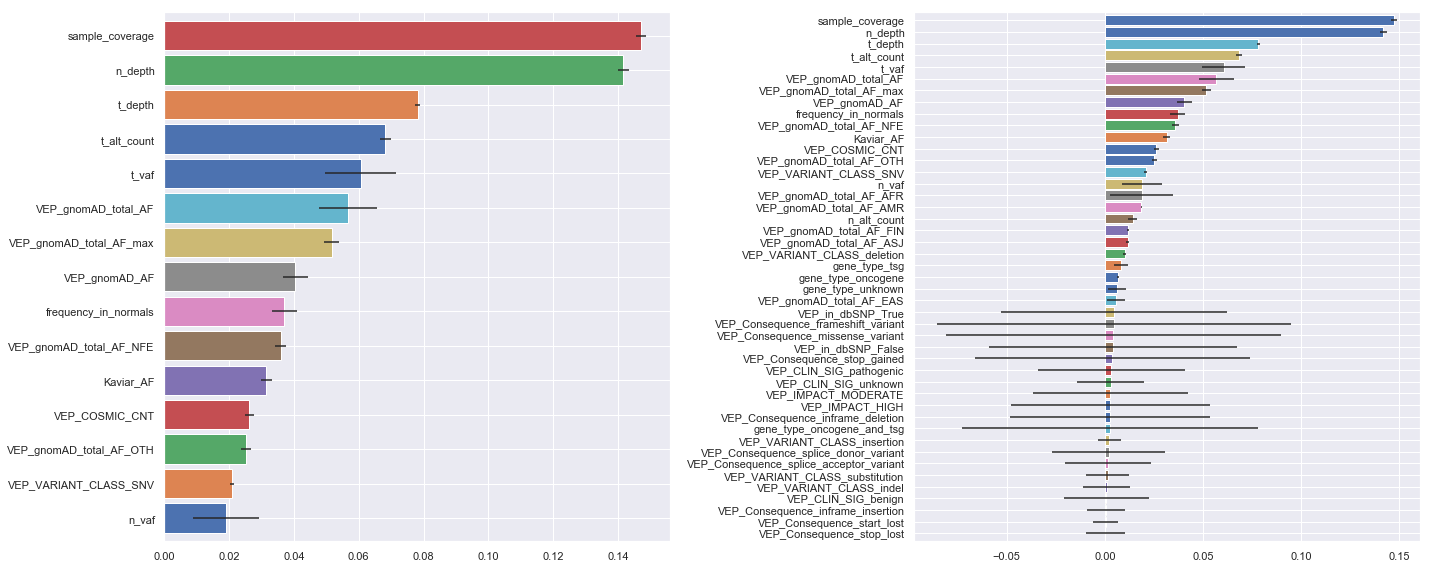

In [58]:
from sklearn.ensemble import RandomForestClassifier

model_bestRF = RandomForestClassifier(random_state=42, n_estimators=1000, max_depth=30, criterion='entropy', n_jobs=5)

for key in dataset_dict.keys():
    print_md('**' + key + '**')

    model_bestRF.fit(dataset_dict[key]['X'], dataset_dict[key]['y']);
    
    feature_importance = pd.DataFrame({'value': model_bestRF.feature_importances_.tolist()}, index=X.columns.tolist())
    feature_importance.sort_values(by='value', axis=0, inplace=True)

    feature_importance['inter_tree_variability'] = np.std([tree.feature_importances_ for tree in model_bestRF.estimators_], axis=0)

    plt.figure(figsize=(20, 8))
    plt.subplot(1, 2, 1)
    feature_importance.tail(15).value.plot.barh(width=0.85, xerr=feature_importance.tail(15).inter_tree_variability)
    plt.subplot(1, 2, 2)
    feature_importance.value.plot.barh(width=0.85, xerr=feature_importance.inter_tree_variability)
    plt.tight_layout()
    
    plt.show()

## Summary

In [45]:
summary = pd.read_pickle('summary_sampling_comparison.pkl')

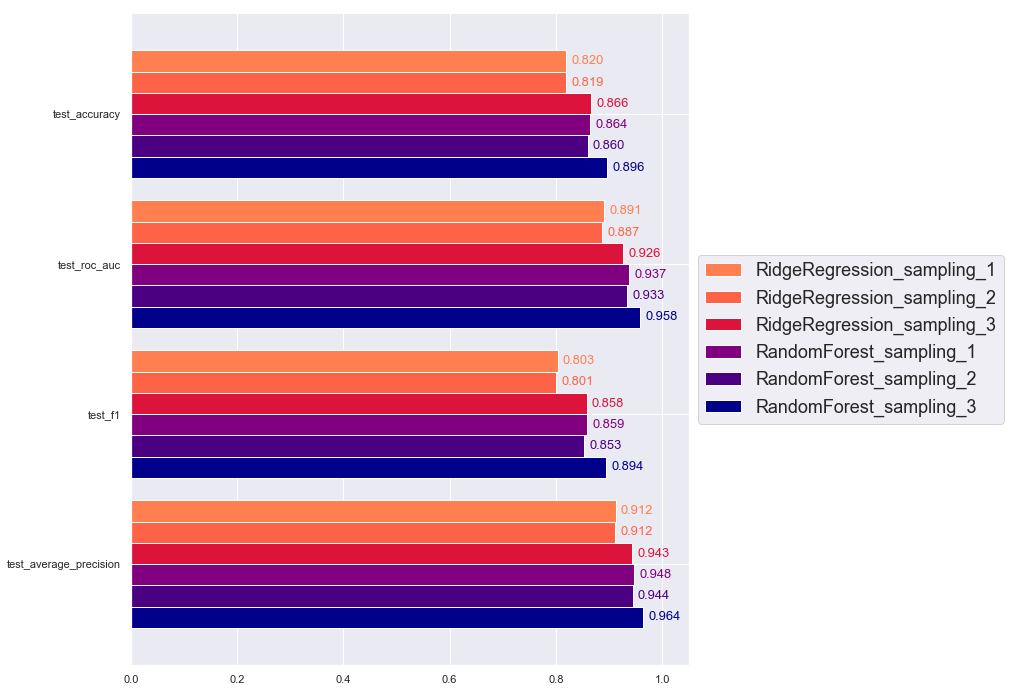

In [46]:
compare_models(summary, ['darkblue', 'indigo', 'purple', 'crimson', 'tomato', 'coral'])

In [18]:
summary.to_pickle('summary_sampling_comparison.pkl')

## Differences between sampling

In [21]:
impact = pd.read_csv('../../../data/annotated_final_IMPACT_mutations_180508.txt', sep='\t', low_memory=False)
impact['is_artefact'] = impact.confidence_class == "UNLIKELY"
get_table(impact.is_artefact)

count_  freq_
False  187012  96.3%
True     7199   3.7%

In [22]:
def plot_reccurence_distribution(data, ax):
    aggregation = {
        'mut_key': {'number': 'count'},
        'VEP_SYMBOL': {'x': lambda x: x.iloc[0]},
        'VEP_gnomAD_total_AF_max': {'x': lambda x: x.iloc[0],
                                    'str': lambda x: '%.2f' % (x.iloc[0] * 100) + '%'}
    }

    dd = data.groupby('mut_key').aggregate(aggregation)
    dd.head()
    
    ax.set_title('Distribution of real mutation reccurent two or more times')
    ax.hist(dd.mut_key.number[dd.mut_key.number > 1], bins=50)
    ax.set_ylim(0, 50)

In [23]:
def get_negative_class(seed):
    return impact[~impact.is_artefact].iloc[seed * positive_class_number:(seed + 1) * positive_class_number]

sampling_1 = get_negative_class(0)
sampling_2 = get_negative_class(1)
sampling_3 = get_negative_class(2)

/Users/guilminp/anaconda3/lib/python3.6/site-packages/pandas/core/groupby/groupby.py:4656: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


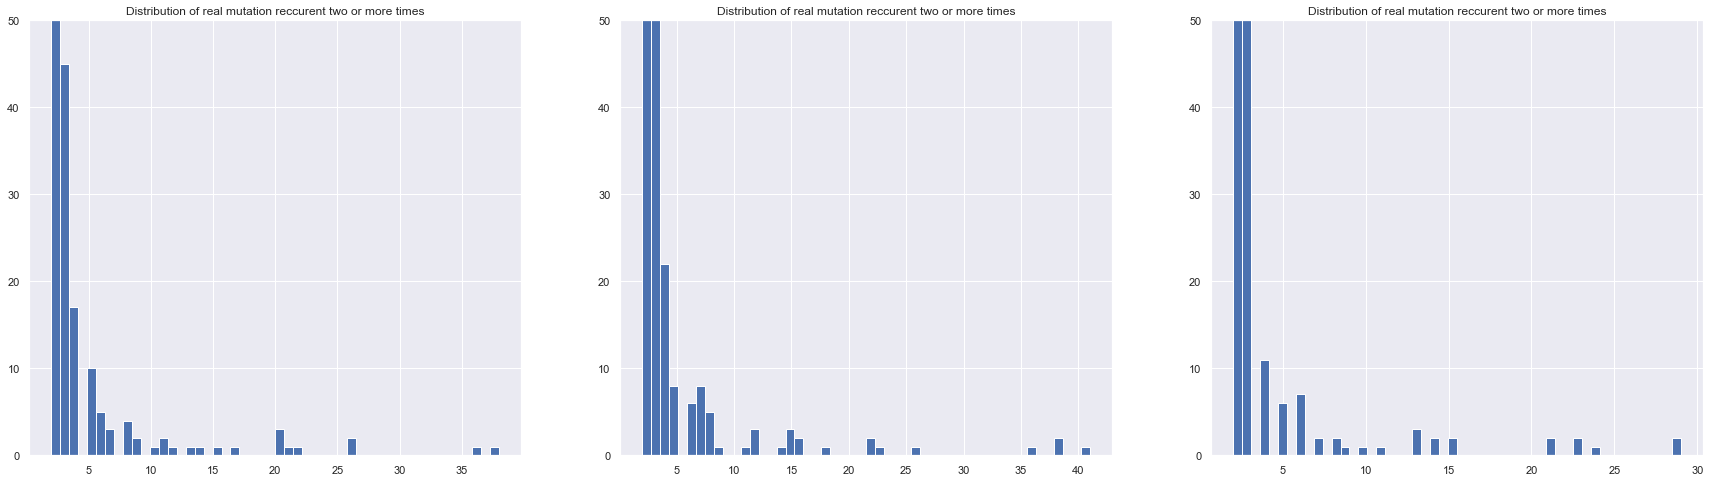

In [24]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 8))
plot_reccurence_distribution(sampling_1, ax1)
plot_reccurence_distribution(sampling_2, ax2)
plot_reccurence_distribution(sampling_3, ax3)

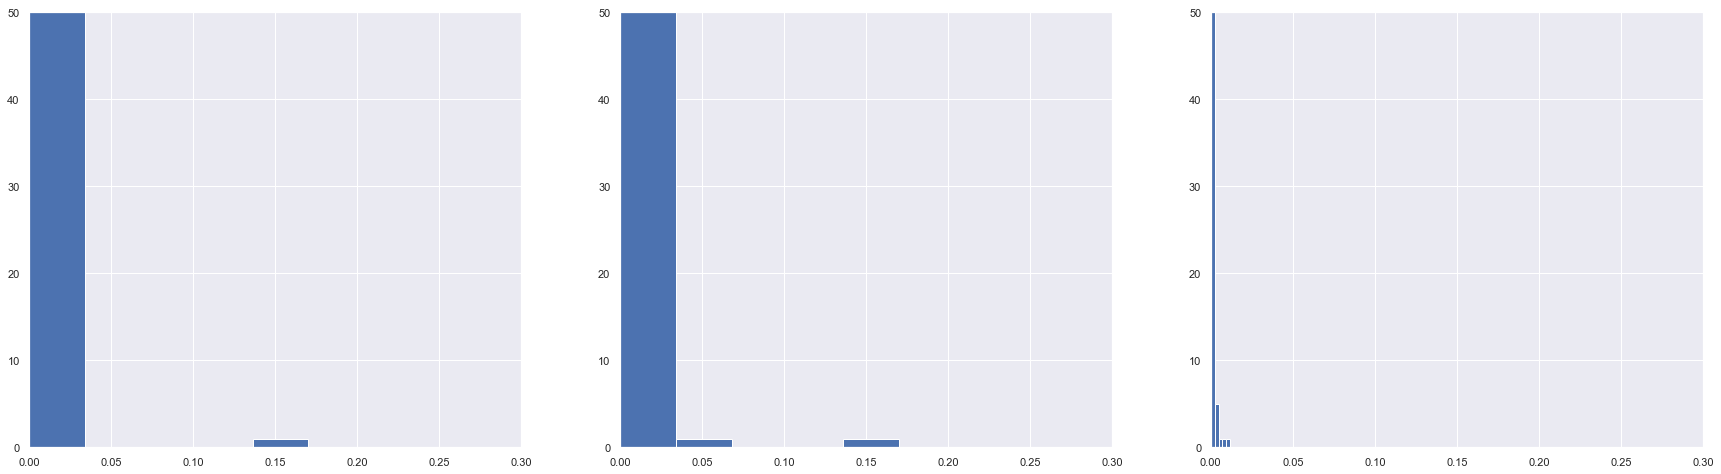

In [25]:
def plot_feature(data, ax, bins, xlim, ylim):
    ax.hist(data, bins=bins)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 8))
plot_feature(sampling_1.VEP_gnomAD_total_AF, ax1, 5, (0, 0.3), (0, 50))
plot_feature(sampling_2.VEP_gnomAD_total_AF, ax2, 5, (0, 0.3), (0, 50))
plot_feature(sampling_3.VEP_gnomAD_total_AF, ax3, 5, (0, 0.3), (0, 50))

## Get the data

In [33]:
# get raw data
impact = pd.read_csv('../../../data/annotated_final_IMPACT_mutations_180508.txt', sep='\t', low_memory=False)
impact['is_artefact'] = impact.confidence_class == "UNLIKELY"
display(get_table(impact.is_artefact))

count_  freq_
False  187012  96.3%
True     7199   3.7%

In [34]:
def get_random_sample(x, max_number):
    if x.shape[0] > max_number:
        return x.sample(max_number, random_state=42).tolist()
    else:
        return x.tolist()

aggregation = {
    'mut_key': {'number': 'count',
                'more_than_three': lambda x: x.count() > 3},
    
    'sample_mut_key': {'list': lambda x: x.tolist(),
                       'selected': lambda x: get_random_sample(x, 3)}
}

dd = impact.groupby('mut_key').aggregate(aggregation)
dd.head(10)

/Users/guilminp/anaconda3/lib/python3.6/site-packages/pandas/core/groupby/groupby.py:4656: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


mut_key                  \
                                  number more_than_three   
mut_key                                                    
10_104263912_G_A                       1           False   
10_104263932_GCGCCCCCGGCCCCACC_-       2           False   
10_104263935_C_-                       1           False   
10_104263935_C_T                       1           False   
10_104263941_G_A                       3           False   
10_104263952_C_-                       1           False   
10_104263959_C_T                       1           False   
10_104263973_-_C                      12            True   
10_104263974_C_-                       3           False   
10_104263979_C_A                       1           False   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                    sample_mut_key  \
                                                                                                                                                                                                                                                                                                                                                                                                                                                                              list   
mut_key                                                                                                                                                                                                                                                                                                                                                                                                                                                                              
10_104263912_G_A                                                                                                                                                                                                                                                                                                                                                                                                                              [P-0004423-T01-IM5_10_104263912_G_A]   
10_104263932_GCGCCCCCGGCCCCACC_-                                                                                                                                                                                                                                                                                                                                          [P-0001027-T01-IM3_10_104263932_GCGCCCCCGGCCCCACC_-, P-0015687-T01-IM6_10_104263932_GCGCCCCCGGCCCCACC_-]   
10_104263935_C_-                                                                                                                                                                                                                                                                                                                                                                                                                              [P-0015938-T01-IM6_10_104263935_C_-]   
10_104263935_C_T                                                                                                                                                                                                                                                                                                                                                                                                                              [P

In [35]:
selected_sample_mut_key = [x for sublist in dd.sample_mut_key.selected for x in sublist]

impact = impact[impact.sample_mut_key.isin(selected_sample_mut_key)].copy()
print(impact.shape)
get_table(impact.is_artefact)

(160752, 64)


count_  freq_
False  155549  96.8%
True     5203   3.2%

In [36]:
label = 'is_artefact'

# choose features
features = ['t_depth', 't_vaf', 't_alt_count', 'n_depth', 'n_vaf', 'n_alt_count', 'sample_coverage', 'frequency_in_normals',
            'VEP_Consequence', 'VEP_VARIANT_CLASS', 'VEP_IMPACT', 'VEP_CLIN_SIG', 'VEP_COSMIC_CNT', 'VEP_gnomAD_AF', 'VEP_in_dbSNP',
            'VEP_gnomAD_total_AF_AFR', 'VEP_gnomAD_total_AF_AMR', 'VEP_gnomAD_total_AF_ASJ', 'VEP_gnomAD_total_AF_EAS', 'VEP_gnomAD_total_AF_FIN',
            'VEP_gnomAD_total_AF_NFE', 'VEP_gnomAD_total_AF_OTH', 'VEP_gnomAD_total_AF_max', 'VEP_gnomAD_total_AF', 'Kaviar_AF',
            'gene_type']
impact = impact[features + [label]].dropna()
    
# transform categorical features
categorical_features = ['VEP_Consequence', 'VEP_VARIANT_CLASS', 'VEP_IMPACT', 'VEP_CLIN_SIG', 'VEP_in_dbSNP', 'gene_type']
numerical_features = [f for f in features if not f in categorical_features]
impact = pd.get_dummies(impact, columns=categorical_features, sparse=True)

In [37]:
positive_class_number = impact[impact.is_artefact].shape[0]

def get_X_and_y(seed):
    # get selected dataset
    impact_selected = pd.concat([impact[impact.is_artefact],
                                 impact[~impact.is_artefact].iloc[seed * positive_class_number:(seed + 1) * positive_class_number]], ignore_index=True)

    # shuffle data
    rng = np.random.RandomState(42)
    permutation = rng.permutation(len(impact_selected))
    impact_selected = impact_selected.iloc[permutation]
    impact_selected.reset_index(drop=True, inplace=True)

    # get features matrix X (n_samples x n_features) and target array y (n_samples)
    X = impact_selected.drop(label, axis=1)
    X = X.astype(float)
    y = impact_selected[label]

    print(X.shape)
    print(y.shape)
    display(get_table(y))
    
    return (X, y)

In [38]:
X_1, y_1 = get_X_and_y(0)
X_2, y_2 = get_X_and_y(1)
X_3, y_3 = get_X_and_y(2)

(10406, 45)
(10406,)


count_  freq_
True     5203  50.0%
False    5203  50.0%

(10406, 45)
(10406,)


count_  freq_
True     5203  50.0%
False    5203  50.0%

(10406, 45)
(10406,)


count_  freq_
True     5203  50.0%
False    5203  50.0%

In [39]:
dataset_dict = {'sampling_1': {'X': X_1, 'y': y_1, 'metrics': pd.DataFrame()},
                'sampling_2': {'X': X_2, 'y': y_2, 'metrics': pd.DataFrame()},
                'sampling_3': {'X': X_3, 'y': y_3, 'metrics': pd.DataFrame()}}

## Set cross-validation strategies

We choose stratified folds (made by preserving the percentage of samples for each class) for both outer and nested cross-validation.

In [40]:
from sklearn.model_selection import StratifiedKFold
cv_strategy = StratifiedKFold(n_splits=5)
nested_cv_strategy = StratifiedKFold(n_splits=3)

## Ridge Regression (L2 regularization)

In [41]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

model = Pipeline([('scale'   , StandardScaler()),
                  ('classify', LogisticRegressionCV(cv=nested_cv_strategy, scoring='roc_auc', random_state=42))])

for key in dataset_dict.keys():
    print_md('**' + key + '**')
    dataset_dict[key]['metrics'] = run_model(model, dataset_dict[key]['X'], dataset_dict[key]['y'], cv_strategy, n_jobs=5)
    print_mean_metrics(dataset_dict[key]['metrics'])

**sampling_1**

Run model... done! (4.37s)
▴ Mean accuracy    : 0.789 ± 0.023
▴ Mean ROC AUC     : 0.861 ± 0.009
▴ Mean F1-score    : 0.768 ± 0.028
▴ Average precision: 0.885 ± 0.010


**sampling_2**

Run model... done! (2.91s)
▴ Mean accuracy    : 0.779 ± 0.024
▴ Mean ROC AUC     : 0.846 ± 0.014
▴ Mean F1-score    : 0.753 ± 0.029
▴ Average precision: 0.877 ± 0.014


**sampling_3**

Run model... done! (2.86s)
▴ Mean accuracy    : 0.816 ± 0.011
▴ Mean ROC AUC     : 0.884 ± 0.010
▴ Mean F1-score    : 0.803 ± 0.011
▴ Average precision: 0.907 ± 0.008


**sampling_1**

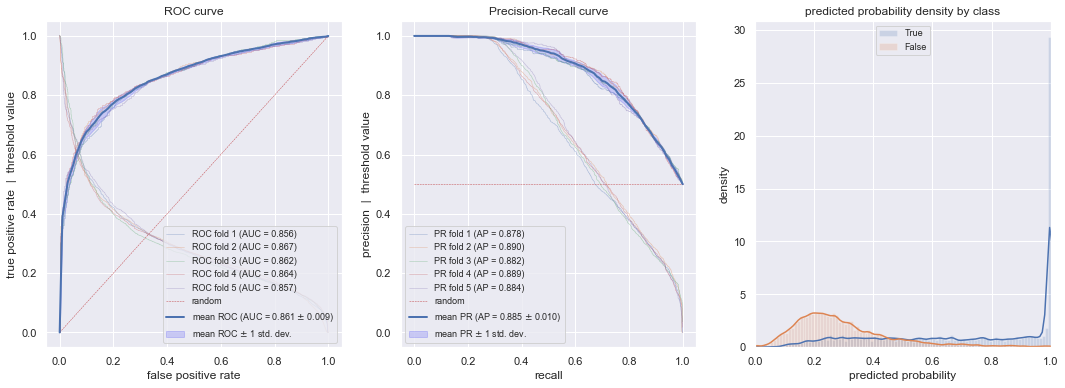

**sampling_2**

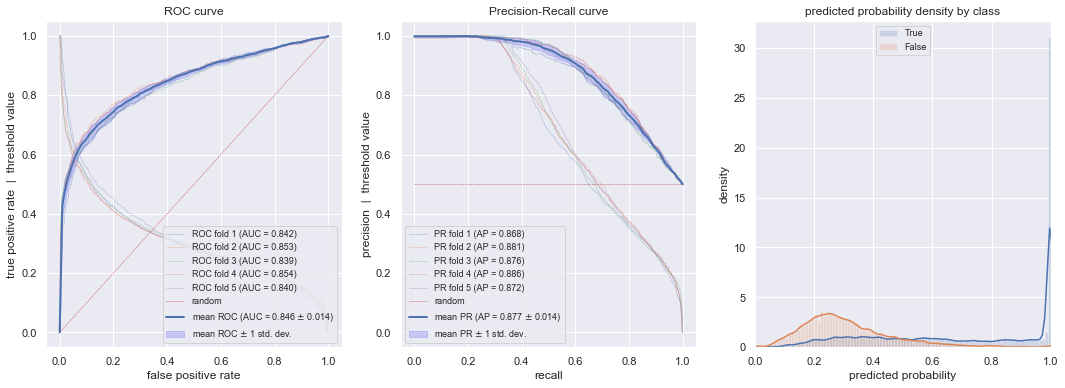

**sampling_3**

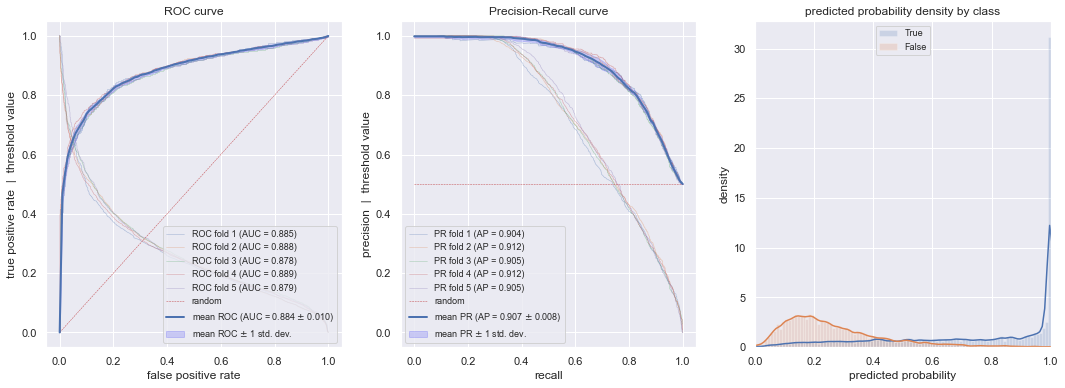

In [42]:
for key in dataset_dict.keys():
    print_md('**' + key + '**')
    plot_threshold_decision_metrics(dataset_dict[key]['metrics'], figsize=(18, 6))
    plt.show()

**sampling_1**

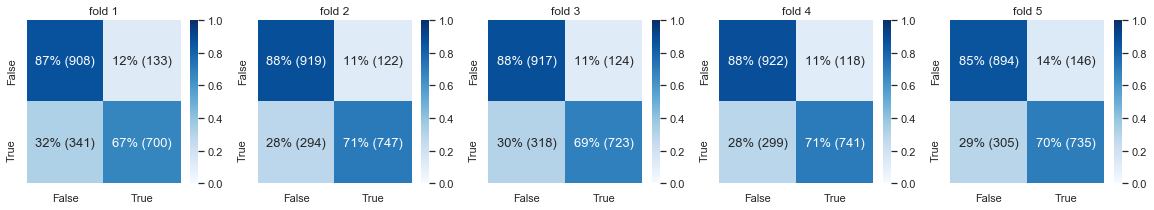

**sampling_2**

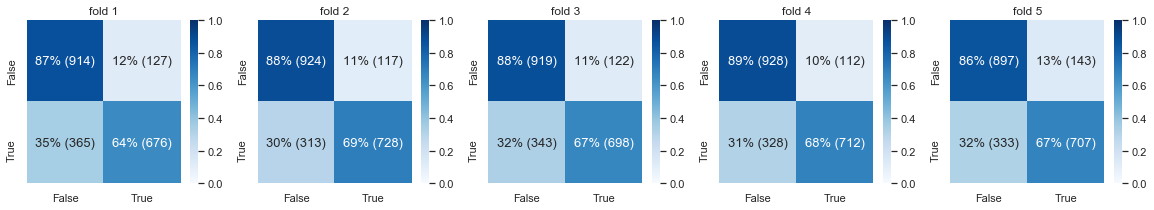

**sampling_3**

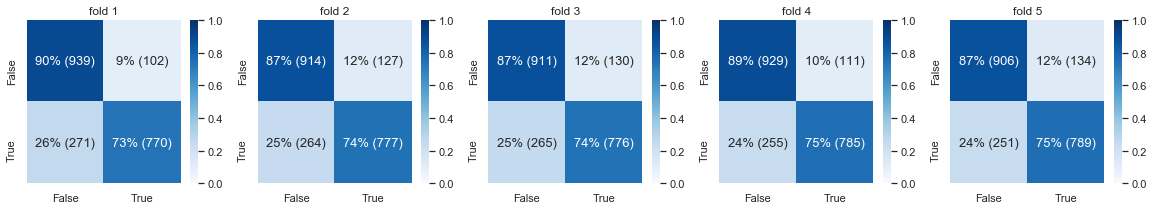

In [43]:
for key in dataset_dict.keys():
    print_md('**' + key + '**')
    plot_confusion_matrix(dataset_dict[key]['metrics'])
    plt.show()

In [47]:
for key in dataset_dict.keys():
    metrics = dataset_dict[key]['metrics']
    summary.loc['RidgeRegression_unified_%s' % key] = [metrics.test_accuracy.mean(), metrics.test_roc_auc.mean(), metrics.test_f1.mean(), metrics.test_average_precision.mean()]

## Random Forest

### Create job

In [48]:
job_list = []
for key in dataset_dict.keys():
    job_list.append(Selene_Job('RandomForest_unified_%s' % key, 'guilminp', '/home/guilminp/impact-annotator', '../ssh_remote_jobs'))

➞ mkdir on local computer ../ssh_remote_jobs/job_RandomForest_unified_sampling_1


<span style="color:green">Job < RandomForest_unified_sampling_1 >: </span>✅ created

➞ mkdir on local computer ../ssh_remote_jobs/job_RandomForest_unified_sampling_2


<span style="color:green">Job < RandomForest_unified_sampling_2 >: </span>✅ created

➞ mkdir on local computer ../ssh_remote_jobs/job_RandomForest_unified_sampling_3


<span style="color:green">Job < RandomForest_unified_sampling_3 >: </span>✅ created

In [147]:
job_list = []
for key in dataset_dict.keys():
    job_list.append(Selene_Job('RandomForest_unified_%s' % key, 'guilminp', '/home/guilminp/impact-annotator', '../ssh_remote_jobs', load_from_id=True))

<span style="color:green">Job < RandomForest_unified_sampling_1 >: </span>✅ job found and reloaded

<span style="color:green">Job < RandomForest_unified_sampling_2 >: </span>✅ job found and reloaded

<span style="color:green">Job < RandomForest_unified_sampling_3 >: </span>✅ job found and reloaded

In [61]:
for job in job_list:
    job.load_data(dataset_dict[job.job_id[21:]]['X'], dataset_dict[job.job_id[21:]]['y'])

➞ save X.pkl & y.pkl in ../ssh_remote_jobs/job_RandomForest_unified_sampling_1


<span style="color:green">Job < RandomForest_unified_sampling_1 >: </span>✅ data loaded

➞ save X.pkl & y.pkl in ../ssh_remote_jobs/job_RandomForest_unified_sampling_2


<span style="color:green">Job < RandomForest_unified_sampling_2 >: </span>✅ data loaded

➞ save X.pkl & y.pkl in ../ssh_remote_jobs/job_RandomForest_unified_sampling_3


<span style="color:green">Job < RandomForest_unified_sampling_3 >: </span>✅ data loaded

In [62]:
%%writefile {job_list[0].script_path}

# load the ml_tools functions
%run ../../ml_tools.py

# load the features matrix and target array
X = pd.read_pickle('X.pkl')
y = pd.read_pickle('y.pkl')

# setup cross-validation and import modules
from sklearn.model_selection import StratifiedKFold
cv_strategy = StratifiedKFold(n_splits=5)
nested_cv_strategy = StratifiedKFold(n_splits=3)

# choose a model and run it
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
parameters_grid = [
    {'n_estimators': [100, 500, 1000, 1500], 'criterion': ['gini', 'entropy'], 'max_depth': [10, 20, 30, 40, 50]}
]
model = GridSearchCV(RandomForestClassifier(random_state=42), parameters_grid, cv=nested_cv_strategy, scoring='roc_auc', refit=True, return_train_score=True)
metrics = run_model(model, X, y, cv_strategy, n_jobs=10)

# save the metrics
print('Save metrics...', end='')
metrics.to_pickle('metrics.pkl')
print(' done!')

Writing ../ssh_remote_jobs/job_RandomForest_unified_sampling_1/script.ipy


In [63]:
!cp {job_list[0].script_path} {job_list[1].script_path}
!cp {job_list[0].script_path} {job_list[2].script_path}

In [64]:
for job in job_list:
    job.run(n_jobs=10, short_job=True, memory=16)

➞ scp ../ssh_remote_jobs/job_RandomForest_unified_sampling_1 to guilminp@selene.mskcc.org:/home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs
script.ipy                                    100%  925     1.4KB/s   00:00    
X.pkl                                         100% 2364KB   2.3MB/s   00:01    
y.pkl                                         100%   11KB  27.9KB/s   00:00    
➞ logged in /home/guilminp on selene.cbio.private
➞ load ~/.bash_profile
Hi Pierre!
➞ work on impact-annotator_env python virtualenv
➞ rm metrics.pkl & job_output.txt in /home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs/job_RandomForest_unified_sampling_1
Job <28727221> is submitted to default queue <sol>.
➞ bsub command used: $ bsub -o job_output.txt -J RandomForest_unified_sampling_1 -We 59 -n 10 -R "span[ptile=5,mem=16]" "ipython script.ipy"


<span style="color:green">Job < RandomForest_unified_sampling_1 >: </span>✅ submitted<br>

➞ scp ../ssh_remote_jobs/job_RandomForest_unified_sampling_2 to guilminp@selene.mskcc.org:/home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs
script.ipy                                    100%  925     1.7KB/s   00:00    
X.pkl                                         100% 2364KB   2.3MB/s   00:01    
y.pkl                                         100%   11KB  28.0KB/s   00:00    
➞ logged in /home/guilminp on selene.cbio.private
➞ load ~/.bash_profile
Hi Pierre!
➞ work on impact-annotator_env python virtualenv
➞ rm metrics.pkl & job_output.txt in /home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs/job_RandomForest_unified_sampling_2
Job <28727266> is submitted to default queue <sol>.
➞ bsub command used: $ bsub -o job_output.txt -J RandomForest_unified_sampling_2 -We 59 -n 10 -R "span[ptile=5,mem=16]" "ipython script.ipy"


<span style="color:green">Job < RandomForest_unified_sampling_2 >: </span>✅ submitted<br>

➞ scp ../ssh_remote_jobs/job_RandomForest_unified_sampling_3 to guilminp@selene.mskcc.org:/home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs
script.ipy                                    100%  925     2.4KB/s   00:00    
X.pkl                                         100% 2364KB   2.3MB/s   00:01    
y.pkl                                         100%   11KB  22.5KB/s   00:00    
➞ logged in /home/guilminp on selene.cbio.private
➞ load ~/.bash_profile
Hi Pierre!
➞ work on impact-annotator_env python virtualenv
➞ rm metrics.pkl & job_output.txt in /home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs/job_RandomForest_unified_sampling_3
Job <28727316> is submitted to default queue <sol>.
➞ bsub command used: $ bsub -o job_output.txt -J RandomForest_unified_sampling_3 -We 59 -n 10 -R "span[ptile=5,mem=16]" "ipython script.ipy"


<span style="color:green">Job < RandomForest_unified_sampling_3 >: </span>✅ submitted<br>

In [148]:
for job in job_list:
    job.get_results()

<span style="color:green">Job < RandomForest_unified_sampling_1 >: </span>✅ finished<br>

➞ scp metrics.pkl & job_output.txt from guilminp@selene.mskcc.org:/home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs/job_RandomForest_unified_sampling_1 to ../ssh_remote_jobs/job_RandomForest_unified_sampling_1
metrics.pkl                                   100%  379KB   3.6MB/s   00:00    
job_output.txt                                100% 1554    91.0KB/s   00:00    
➞ load metrics.pkl in pandas dataframe self.metrics
➞ print main results
▴ Mean accuracy    : 0.838 ± 0.005
▴ Mean ROC AUC     : 0.916 ± 0.004
▴ Mean F1-score    : 0.833 ± 0.008
▴ Average precision: 0.929 ± 0.004


<span style="color:green">Job < RandomForest_unified_sampling_2 >: </span>✅ finished<br>

➞ scp metrics.pkl & job_output.txt from guilminp@selene.mskcc.org:/home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs/job_RandomForest_unified_sampling_2 to ../ssh_remote_jobs/job_RandomForest_unified_sampling_2
metrics.pkl                                   100%  389KB   6.8MB/s   00:00    
job_output.txt                                100% 1555    73.7KB/s   00:00    
➞ load metrics.pkl in pandas dataframe self.metrics
➞ print main results
▴ Mean accuracy    : 0.831 ± 0.022
▴ Mean ROC AUC     : 0.904 ± 0.010
▴ Mean F1-score    : 0.823 ± 0.024
▴ Average precision: 0.918 ± 0.011


<span style="color:green">Job < RandomForest_unified_sampling_3 >: </span>✅ finished<br>

➞ scp metrics.pkl & job_output.txt from guilminp@selene.mskcc.org:/home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs/job_RandomForest_unified_sampling_3 to ../ssh_remote_jobs/job_RandomForest_unified_sampling_3
metrics.pkl                                   100%  390KB   3.3MB/s   00:00    
job_output.txt                                100% 1554   299.2KB/s   00:00    
➞ load metrics.pkl in pandas dataframe self.metrics
➞ print main results
▴ Mean accuracy    : 0.856 ± 0.009
▴ Mean ROC AUC     : 0.926 ± 0.008
▴ Mean F1-score    : 0.852 ± 0.010
▴ Average precision: 0.936 ± 0.005


**RandomForest_unified_sampling_1**

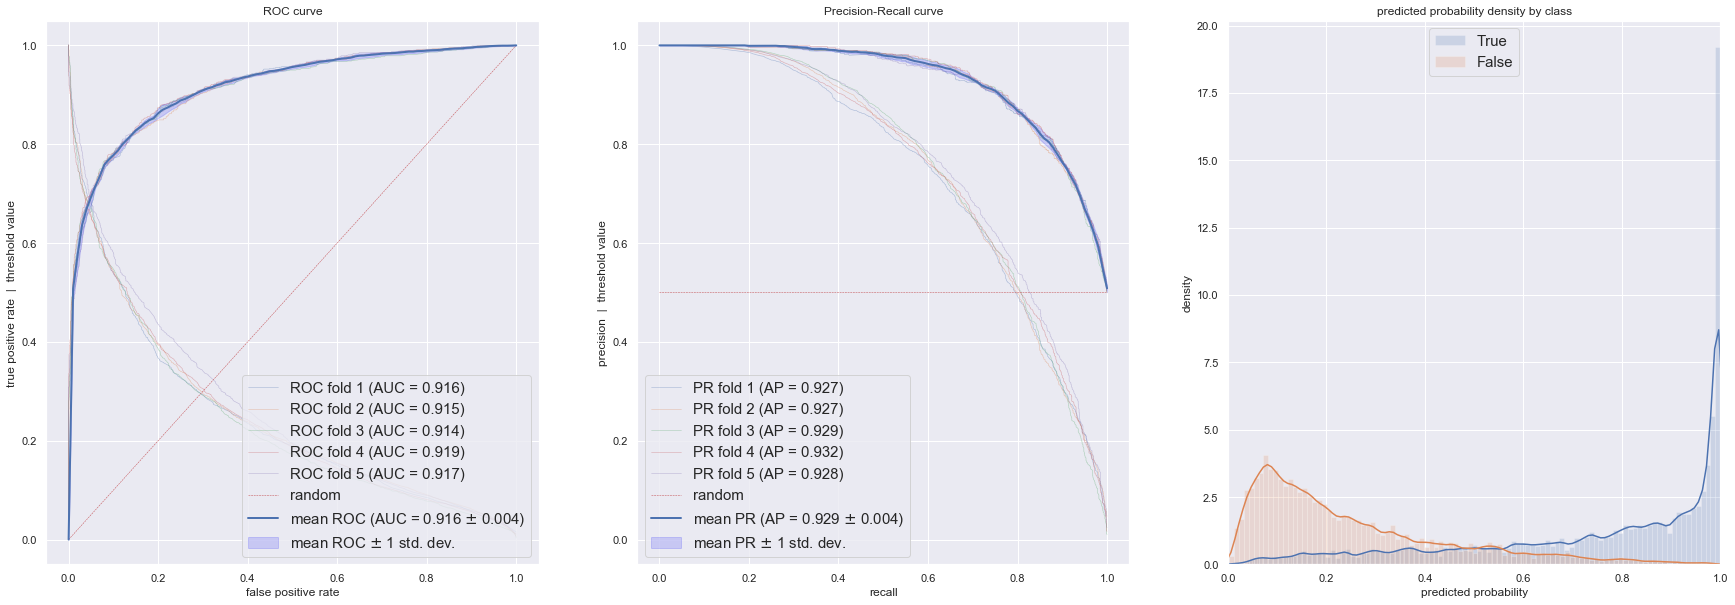

**RandomForest_unified_sampling_2**

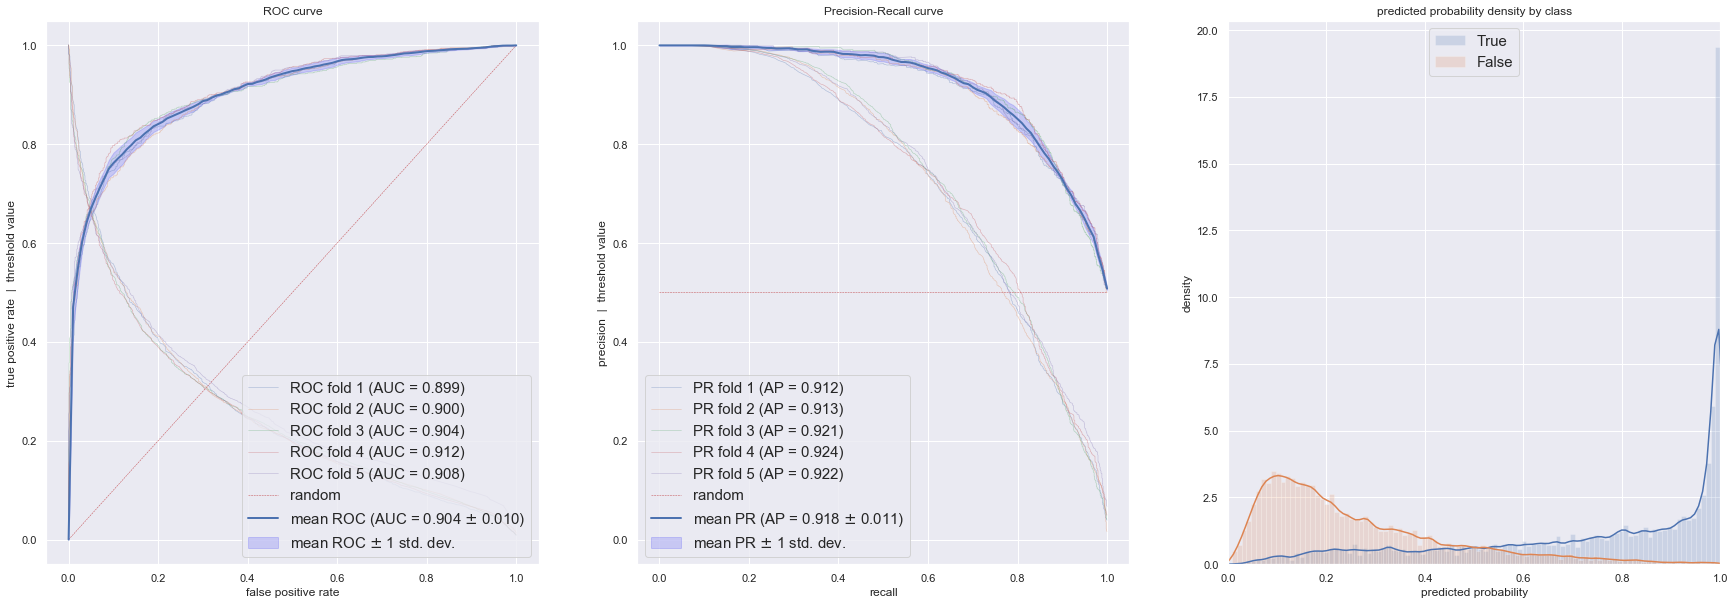

**RandomForest_unified_sampling_3**

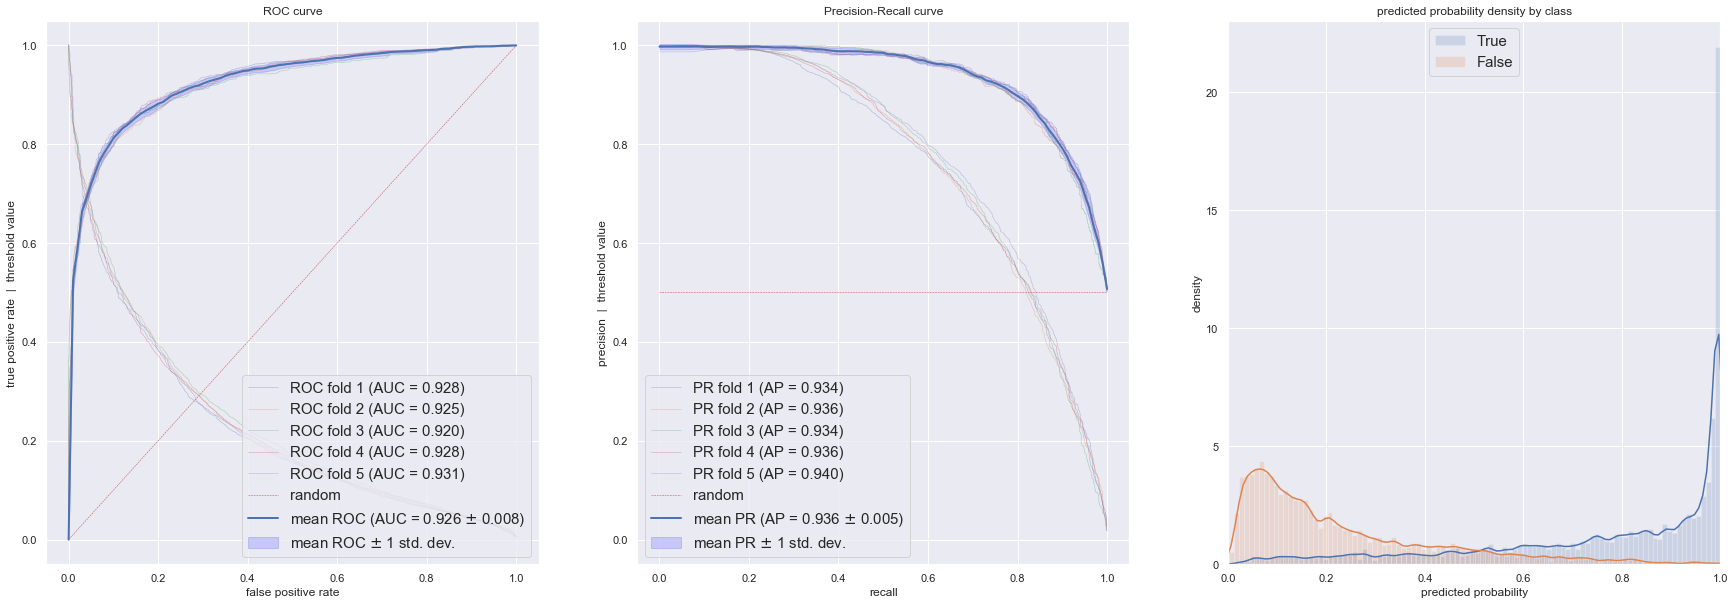

In [149]:
for job in job_list:
    if hasattr(job, 'metrics'):
        print_md('**' + job.job_id + '**')
        plot_threshold_decision_metrics(job.metrics)
        plt.show()

**RandomForest_unified_sampling_1**

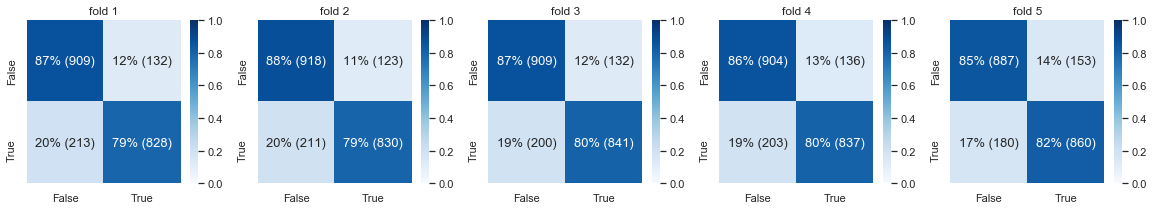

**RandomForest_unified_sampling_2**

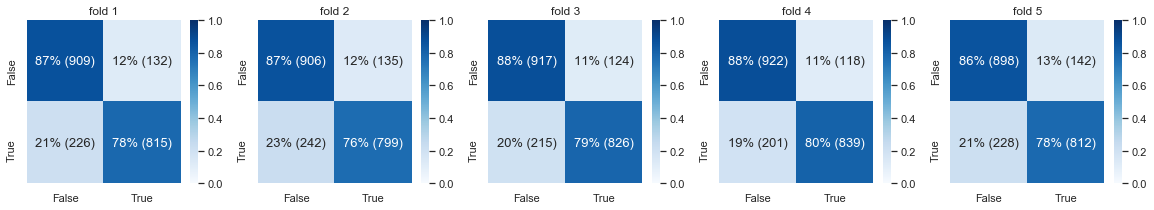

**RandomForest_unified_sampling_3**

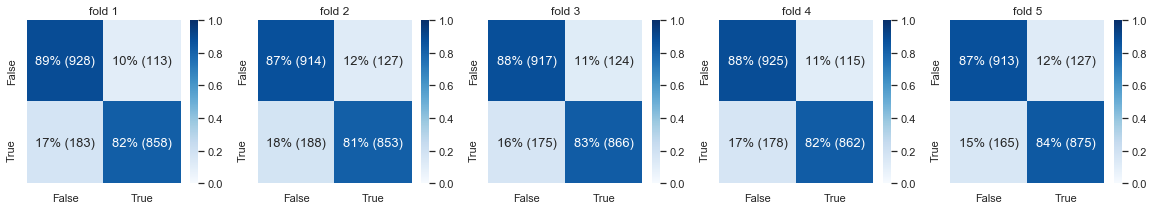

In [150]:
for job in job_list:
    if hasattr(job, 'metrics'):
        print_md('**' + job.job_id + '**')
        plot_confusion_matrix(job.metrics)
        plt.show()

**RandomForest_unified_sampling_1**

3 hyperparameters tuned for 5 different folds (over a 3-fold nested cross-validation):
  → criterion   : ['entropy' 'gini']
  → max_depth   : [10 20 30 40 50]
  → n_estimators: [100 500 1000 1500]
Best hyperparameters for each fold:
fold 0: {'criterion': 'entropy', 'max_depth': 30, 'n_estimators': 1000}
fold 1: {'criterion': 'entropy', 'max_depth': 30, 'n_estimators': 1500}
fold 2: {'criterion': 'entropy', 'max_depth': 50, 'n_estimators': 1000}
fold 3: {'criterion': 'entropy', 'max_depth': 30, 'n_estimators': 1000}
fold 4: {'criterion': 'entropy', 'max_depth': 30, 'n_estimators': 1000}


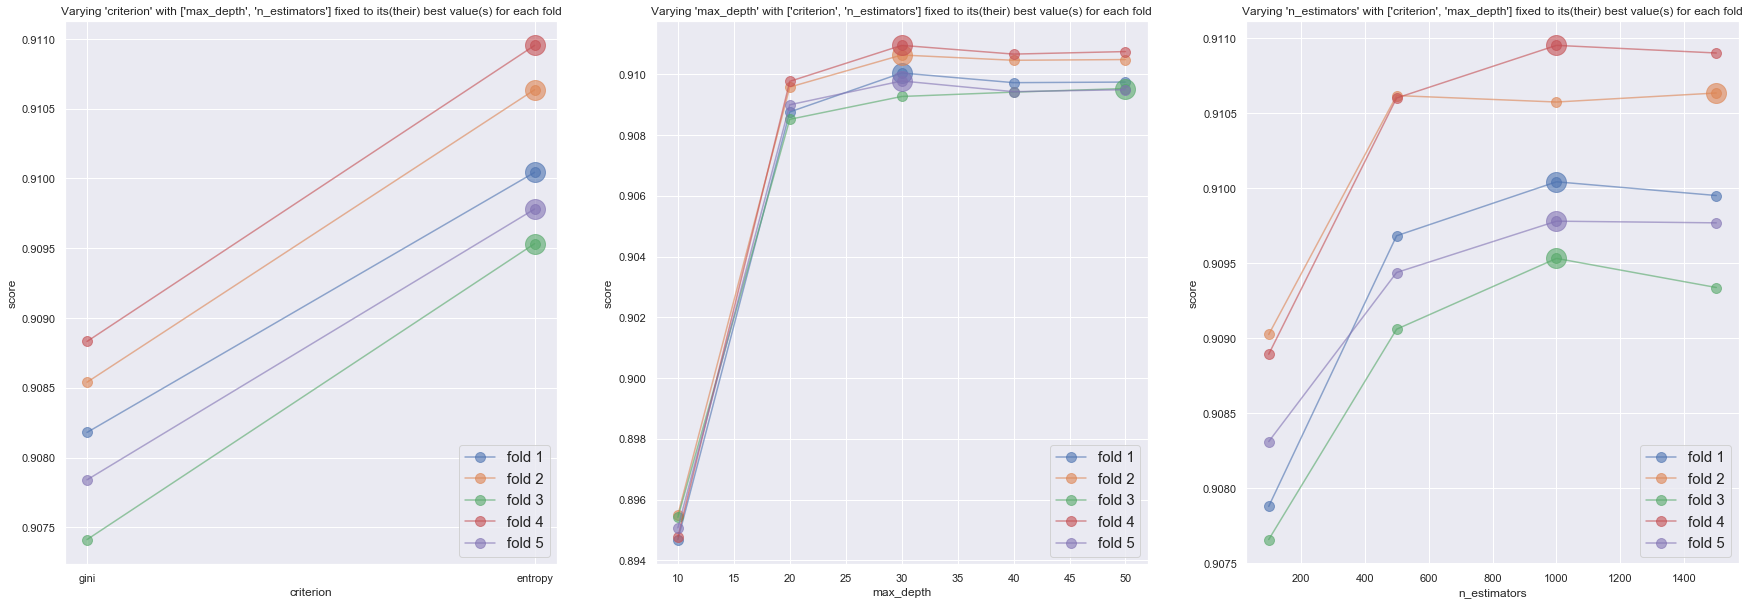

**RandomForest_unified_sampling_2**

3 hyperparameters tuned for 5 different folds (over a 3-fold nested cross-validation):
  → criterion   : ['entropy' 'gini']
  → max_depth   : [10 20 30 40 50]
  → n_estimators: [100 500 1000 1500]
Best hyperparameters for each fold:
fold 0: {'criterion': 'entropy', 'max_depth': 40, 'n_estimators': 500}
fold 1: {'criterion': 'entropy', 'max_depth': 30, 'n_estimators': 500}
fold 2: {'criterion': 'entropy', 'max_depth': 30, 'n_estimators': 1500}
fold 3: {'criterion': 'entropy', 'max_depth': 30, 'n_estimators': 1500}
fold 4: {'criterion': 'entropy', 'max_depth': 20, 'n_estimators': 1500}


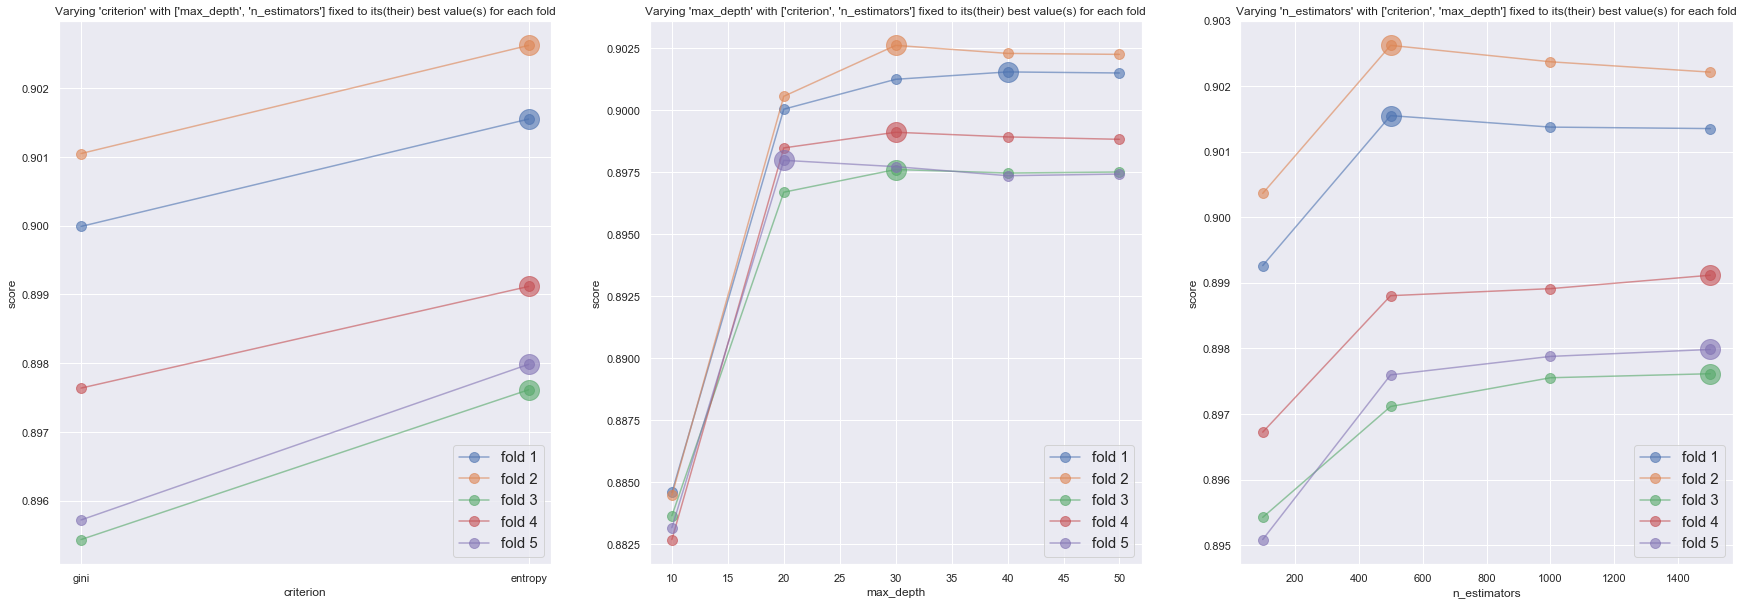

**RandomForest_unified_sampling_3**

3 hyperparameters tuned for 5 different folds (over a 3-fold nested cross-validation):
  → criterion   : ['entropy' 'gini']
  → max_depth   : [10 20 30 40 50]
  → n_estimators: [100 500 1000 1500]
Best hyperparameters for each fold:
fold 0: {'criterion': 'entropy', 'max_depth': 40, 'n_estimators': 1000}
fold 1: {'criterion': 'entropy', 'max_depth': 40, 'n_estimators': 1500}
fold 2: {'criterion': 'entropy', 'max_depth': 30, 'n_estimators': 1500}
fold 3: {'criterion': 'entropy', 'max_depth': 30, 'n_estimators': 1500}
fold 4: {'criterion': 'entropy', 'max_depth': 30, 'n_estimators': 1500}


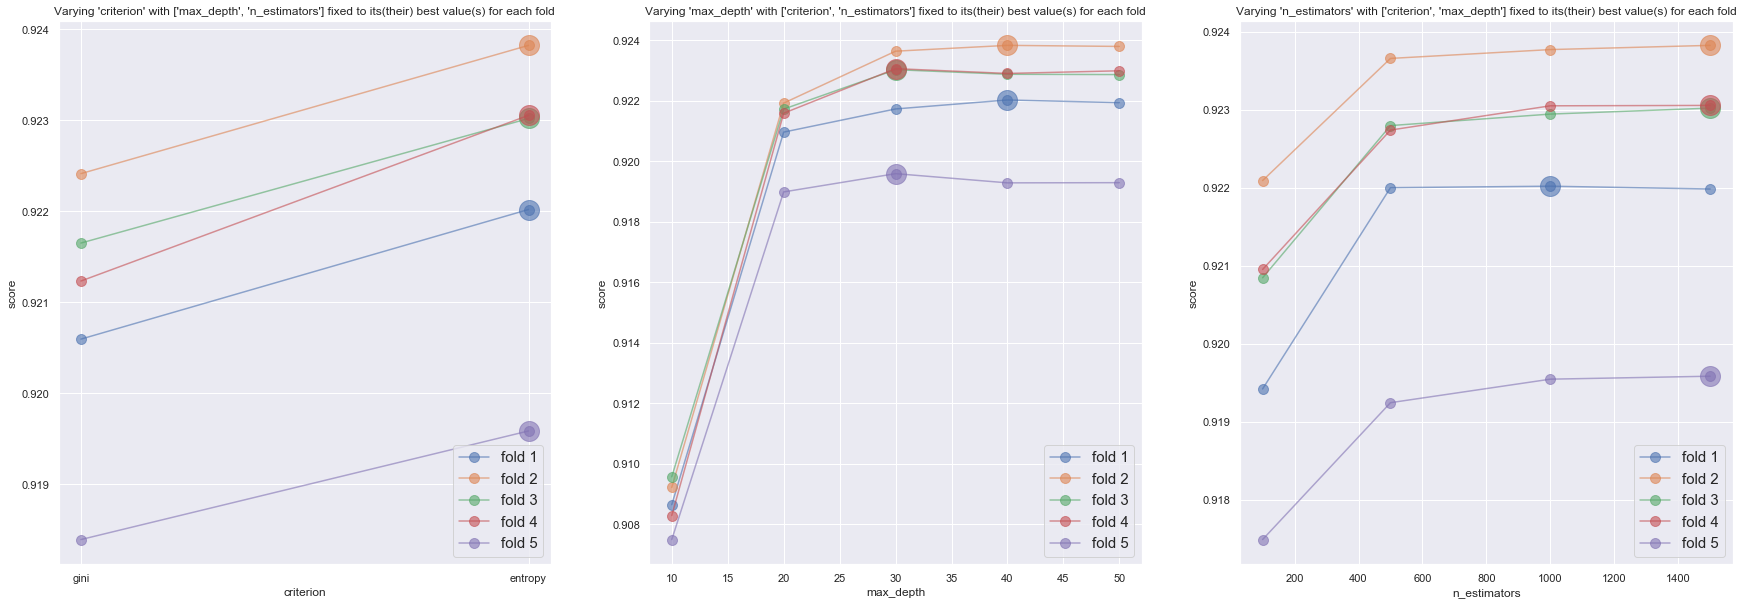

In [151]:
for job in job_list:
    if hasattr(job, 'metrics'):
        print_md('**' + job.job_id + '**')
        plot_grid_search_results(job.metrics, plot_error_bar=False)
        plt.show()

In [152]:
for job in job_list:
    if hasattr(job, 'metrics'):
        summary.loc[job.job_id] = [job.metrics.test_accuracy.mean(), job.metrics.test_roc_auc.mean(), job.metrics.test_f1.mean(), job.metrics.test_average_precision.mean()]

## Summary

In [19]:
summary = pd.read_pickle('summary_sampling_comparison.pkl')

In [156]:
%run ../ml_tools.py

<Figure size 432x288 with 0 Axes>

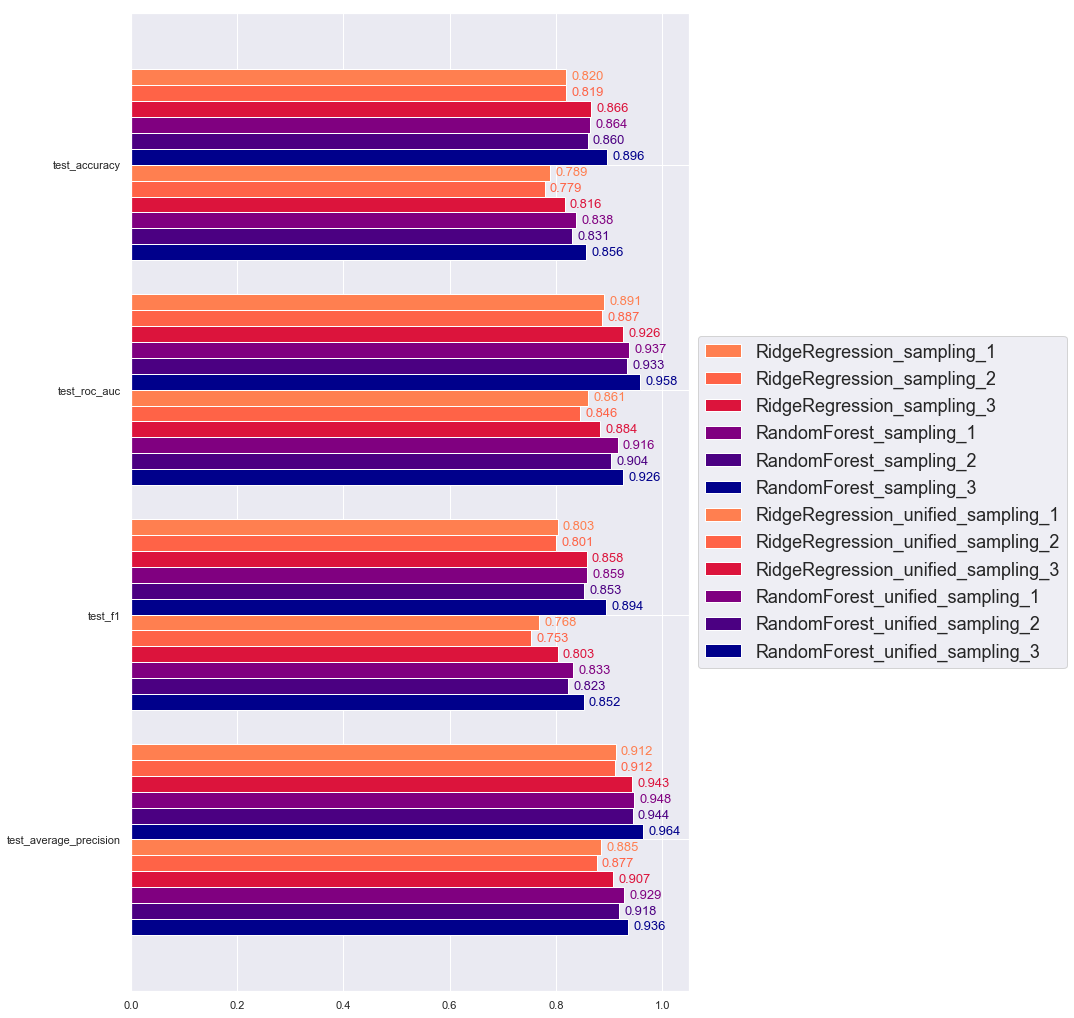

In [160]:
compare_models(summary, ['darkblue', 'indigo', 'purple', 'crimson', 'tomato', 'coral'], figsize=(10, 18))

In [18]:
summary.to_pickle('summary_sampling_comparison.pkl')

In [242]:
%run ../ml_tools.py

In [243]:
summary2 = pd.DataFrame(columns=['test_accuracy_mean', 'test_roc_auc_mean', 'test_f1_mean', 'test_average_precision_mean',
                                 'test_accuracy_std' , 'test_roc_auc_std' , 'test_f1_std', 'test_average_precision_std'])
summary2.index.name = 'sampling_strategy'

In [244]:
for key in dataset_dict.keys():
    add_metrics_to_summary(summary2, dataset_dict[key]['metrics'], 'RidgeRegression_unified_%s' % key)

In [245]:
summary2[['test_accuracy_std', 'test_f1_std', 'test_roc_auc_std', 'test_average_precision_std']]

test_accuracy_std  test_f1_std  \
sampling_strategy                                                    
RidgeRegression_unified_sampling_1           0.011709     0.014194   
RidgeRegression_unified_sampling_2           0.012246     0.015034   
RidgeRegression_unified_sampling_3           0.005819     0.005446   

                                    test_roc_auc_std  \
sampling_strategy                                      
RidgeRegression_unified_sampling_1          0.004559   
RidgeRegression_unified_sampling_2          0.007206   
RidgeRegression_unified_sampling_3          0.004885   

                                    test_average_precision_std  
sampling_strategy                                               
RidgeRegression_unified_sampling_1                    0.005025  
RidgeRegression_unified_sampling_2                    0.006931  
RidgeRegression_unified_sampling_3                    0.003981

In [286]:
def compare_models(data, colors=None, metrics=['test_accuracy', 'test_f1', 'test_roc_auc', 'test_average_precision']):
    display(data.style.highlight_max(axis=0, color='yellow').set_precision(3))
    data = data.copy()
    data = data.iloc[::-1].transpose().iloc[::-1]
    
    fig, ax = plt.subplots(1, 1, figsize=(10, 12))
    if not colors:
        colors = ['darkblue', 'purple', 'grey', 'maroon', 'crimson', 'salmon', 'darkgoldenrod', 'seagreen', 'mediumseagreen']

    metrics_mean = data.loc[['%s_mean' % m for m in metrics]]
    metrics_std  = data.loc[['%s_std'  % m for m in metrics]]
    metrics_std.index = metrics_mean.index

    metrics_mean.plot.barh(ax=ax, width=0.85, color=colors, xerr=metrics_std, error_kw={'ecolor': 'black', 'capsize': 3})
    
    for line in ax.lines:
        print(line.get_xdata())
        print()
        
    # print text results
    for rect in ax.patches:
        print(rect.get_width() + 0.01, rect.get_y() + rect.get_height() / 2)
        ax.text(rect.get_width() + 0.01, rect.get_y() + rect.get_height() / 2,
                '%.3f' % rect.get_width(), ha='left', va='center', color=rect.get_facecolor(), fontsize=13)

    # invert legend order
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[::-1], labels[::-1], loc='center left', bbox_to_anchor=(1, 0.5), prop={'size':18})
    ax.set_xlim(right=1.05)

[0.8106341673107131, 0.7977414318296692, 0.8789901112542532, 0.9035031358947742]

[0.8222722466403691, 0.8086329028490691, 0.8887596511310606, 0.911464592077683]

[0.76644008686513, 0.738450702492556, 0.8384386203529747, 0.86984857642603]

[0.7909315232730507, 0.7685188752416843, 0.8528514365058967, 0.8837103822755976]

[0.7768752479001869, 0.7539637873064576, 0.8565848298683263, 0.8795928113812903]

[0.800293894196909, 0.7823526414261975, 0.8657036243172378, 0.8896420889732222]

0.8264532069755411 -0.2833333333333333
0.8131871673393691 0.7166666666666666
0.8938748811926569 1.7166666666666666
0.9174838639862286 2.716666666666667
0.7886858050690904 0.0
0.7634847888671201 1.0
0.8556450284294357 2.0
0.8867794793508138 3.0
0.798584571048548 0.28333333333333327
0.7781582143663276 1.2833333333333332
0.871144227092782 2.283333333333333
0.8946174501772562 3.283333333333333


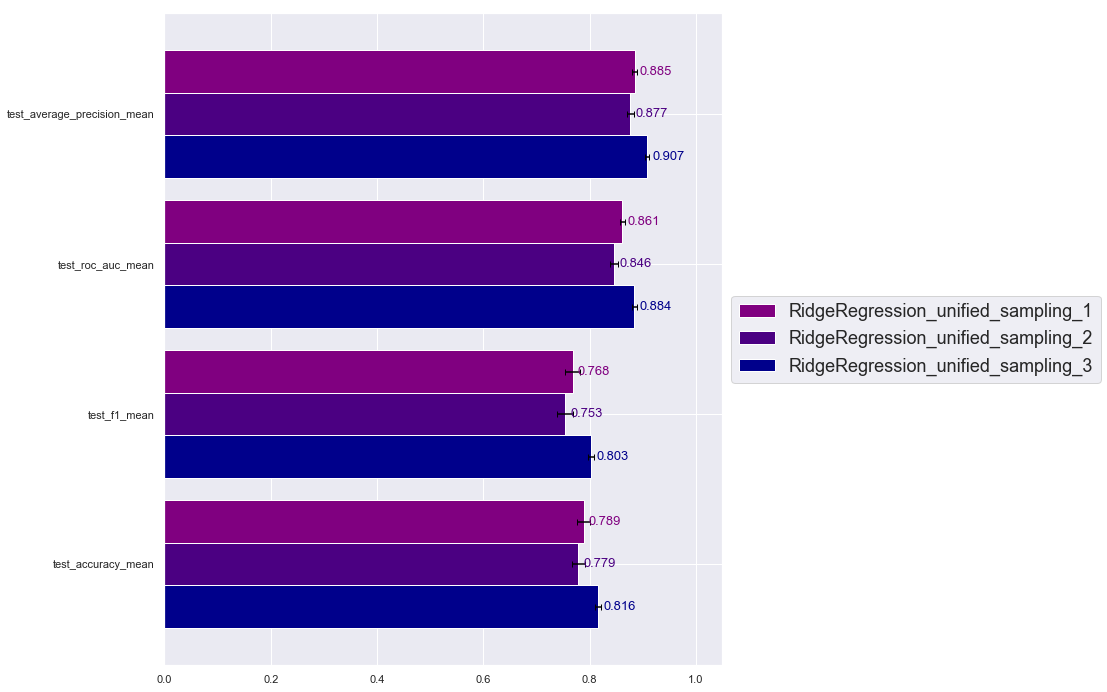

In [287]:
compare_models(summary2, ['darkblue', 'indigo', 'purple', 'crimson', 'tomato', 'coral'])